Stem tokens (using Porter stemmer) and insert tokens from docs into inverted index

In [1]:
import os

import nltk
from InvertedIndex import InvertedIndex  # Custom library
from ModelResults import ModelResults
from nltk.stem import PorterStemmer
from VectorSpace import VectorSpace

docs_path = "../Dataset/docs/"
docs_list = os.listdir(docs_path)

# Used later for query preprocessing
removed_frequent_words = []
replaced_words = {}

invertedIndex = InvertedIndex()
ps = PorterStemmer()

for doc_name in docs_list:
    file_path = os.path.join(docs_path, doc_name)
    doc = open(file_path)
    for token in doc:
        invertedIndex.insert(ps.stem(token[:-1].lower()), doc_name)
    doc.close()

Filter inverted tokens words using stopwords and replace tokens with synonyms

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
stopwords = stopwords.words("english")

for word in stopwords:
    invertedIndex.delete(ps.stem(word))

[nltk_data] Downloading package stopwords to /home/greg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plot token frequency distribution in filtered inverted index

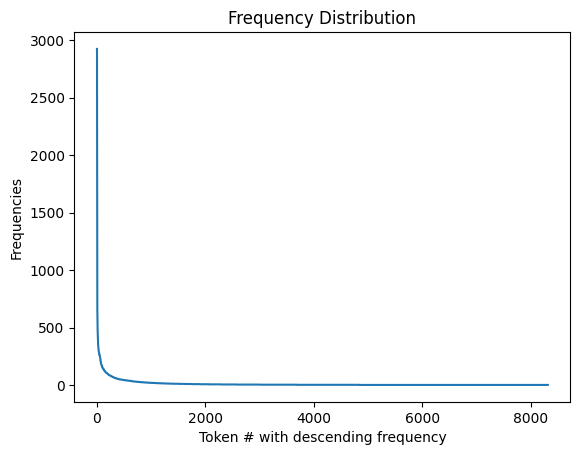

In [3]:
import operator

import matplotlib.pyplot as plt


def plotFrequencyDistribution():
    tokenFrequencies = {}
    for token, data in invertedIndex.getTokens():
        tokenFrequencies[token] = invertedIndex.countOccurances(token)
    tokenFrequencies = dict(
        sorted(tokenFrequencies.items(), key=operator.itemgetter(1), reverse=True)
    )
    plt.plot(
        range(len(list(tokenFrequencies.values()))), list(tokenFrequencies.values())
    )
    plt.title("Frequency Distribution")
    plt.xlabel("Token # with descending frequency")
    plt.ylabel("Frequencies")
    plt.show()
    return tokenFrequencies


tokenFrequencies = plotFrequencyDistribution()

As you can see, very few tokens are very frequent and the rest is very infrequent.

Thus I decided to remove very frequent tokens, that appear on mostly every document, since I don't want the information retrieval system to focus on those when computing answers to queries.

I also replaced infrequent tokens with synonyms, hoping that the synonyms would have a higher frequency in the docs, so that by doing the same replacements in the query tokens the answers of the infrequent tokens will be grouped with their synonyms.

I set the thresholds for the frequent token removal and the infrequent token replacement so that when later plotting the Frequency Distribution graph again, I will only have the "knee" of the currrent graph. This is an emperical rule to make sure that we don't have many very frequent or very infrequent tokens in the inverted index

In [4]:
from nltk.corpus import wordnet

nltk.download("wordnet")

# Remove frequent tokens
for token, frequency in tokenFrequencies.items():
    if frequency > 500:
        invertedIndex.delete(token)
        removed_frequent_words.append(token)
    else:
        break

# Replace infrequent words with synonyms
for token, frequency in reversed(tokenFrequencies.items()):
    if frequency < 5:
        synonyms = wordnet.synsets(token)
        for synonym in synonyms:
            new_token = ps.stem(synonym.lemmas()[0].name())  # type: ignore
            if (
                new_token != token
                and "_" not in new_token
                and new_token in invertedIndex.getTokens()
            ):
                replaced_words[token] = new_token
                invertedIndex.rename(token, new_token)
                break
    else:
        break

[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now i plot the frequency distribution again in order to evaluate what it looks like

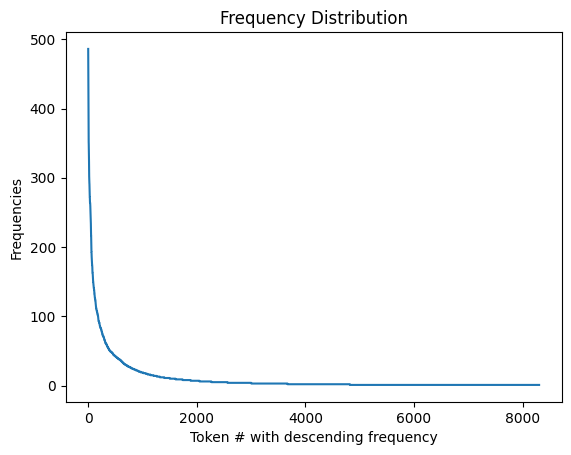

In [5]:
tokenFrequencies = plotFrequencyDistribution()

It is visible now that we are left with the "knee" of the original frequency distribution, so all very frequent and all very infrequent tokens are removed.
Now let's enter the documents and queries into the Vector Space Model:

In [6]:
with open("../Dataset/Queries_20") as queries:
    vectorSpace1 = VectorSpace(
        documents=docs_list,
        queries=queries,
        invertedIndex=invertedIndex,
        document_tf_weighting=VectorSpace.tf_simplefrequency,
        document_idf_weighting=VectorSpace.idf_logsimple,
        document_normalize_function=VectorSpace.cosine_normalization,
        query_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        query_idf_weighting=VectorSpace.idf_logsimple,
        query_normalize_function=VectorSpace.no_normalization,
        query_stopwords=stopwords,
        query_removed_frequent_words=removed_frequent_words,
        query_replaced_words=replaced_words,
        query_stemmer=ps,
    )

with open("../Dataset/Queries_20") as queries:
    vectorSpace2 = VectorSpace(
        documents=docs_list,
        queries=queries,
        invertedIndex=invertedIndex,
        document_tf_weighting=VectorSpace.tf_simplefrequency,
        document_idf_weighting=VectorSpace.idf_one,
        document_normalize_function=VectorSpace.cosine_normalization,
        query_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        query_idf_weighting=VectorSpace.idf_logsimple,
        query_normalize_function=VectorSpace.no_normalization,
        query_stopwords=stopwords,
        query_removed_frequent_words=removed_frequent_words,
        query_replaced_words=replaced_words,
        query_stemmer=ps,
    )

['effect', 'calcium', 'physic', 'properti', 'mucu']
['one', 'distinguish', 'effect', 'mucu', 'hypersecret', 'infect', 'submucos', 'gland', 'respiratori', 'tract']
['salivari', 'glycoprotein', 'differ', 'subject']
['lipid', 'composit', 'respiratori', 'secret']
['mucu', 'abnorm']
['effect', 'water', 'therapeut', 'agent', 'physic', 'properti', 'viscos', 'elast', 'sputum', 'bronchial', 'secret']
['mucu', 'glycoprotein', 'degrad', 'differ', 'compar', 'subject']
['histochem', 'differ', 'describ', 'respiratori', 'epithelia']
['associ', 'liver', 'cirrhosi', 'vitamin', 'metabol']
['role', 'vitamin', 'e', 'therapi']
['differ', 'meconium', 'ileu', 'meconium', 'plug', 'syndrom']
['abnorm', 'amino', 'acid', 'transport', 'describ', 'small', 'bowel']
['clinic', 'biochem', 'featur', 'pancreat']
['non-invas', 'perform', 'evalu', 'exocrin', 'pancreat', 'function']
['hepat', 'complic', 'manifest']
['gastrointestin', 'complic', 'neonat', 'period', 'exclud', 'liver', 'meconium', 'ileu']
['effect', 'regimen

In [7]:
vectorSpace1Results = [vectorSpace1.lookup(str(i), 40) for i in range(20)]
vectorSpace2Results = [vectorSpace2.lookup(str(i), 40) for i in range(20)]

In [8]:
import csv
import os

docs_path = "../Dataset/docs/"
docs_list = sorted(os.listdir(docs_path))
queries = "../Dataset/Queries_20"
relevant = "../Dataset/cfquery_detailed"

previous_doc_name = 0
count = 0
missing = []
for doc_name in docs_list:
    if (int(doc_name) - int(previous_doc_name)) != 1:
        for i in range(1, int(doc_name) - int(previous_doc_name)):
            missing.append(int(doc_name) - i)
        count += 1
    previous_doc_name = doc_name
print(f"Missing count: {count}")
print(f"Missing {missing}")

Missing count: 28
Missing [129, 132, 200, 213, 219, 282, 296, 343, 397, 465, 489, 492, 491, 508, 507, 513, 537, 627, 724, 902, 926, 940, 1013, 1033, 1103, 1134, 1138, 1184, 1190, 1225]


Because ColBERT needs incremental cids, I create a dictionary mapping incremental cids to doc ids

In [9]:
cid_dictionary = {}
i = 0
for doc_name in docs_list:
    cid_dictionary[doc_name.lstrip("0")] = i
    i += 1

inverted_cid_dictionary = {v: k for k, v in cid_dictionary.items()}

Preprocess the data into Tab Separated Values (TSV)

In [10]:
import operator


def processRelevantIntoRanking(relevant_string, query_id):
    relevant_string = relevant_string.split()
    relevant_order = {}
    flag = False
    for text in relevant_string:
        if not flag:
            if text in cid_dictionary:
                doc_id = cid_dictionary[text]
                flag = True
            else:
                continue
        else:
            score = 0
            for digit in text:
                score += int(digit)
            score /= len(text)
            relevant_order[doc_id] = score
            flag = False
    relevant_order = dict(
        sorted(relevant_order.items(), key=operator.itemgetter(1), reverse=True)
    )
    i = 1
    for doc_id in relevant_order:
        relevant_order[doc_id] = i
        i += 1
    return relevant_order

In [11]:
import csv
import os

docs_path = "../Dataset/docs/"
docs_list = sorted(os.listdir(docs_path))
queries = "../Dataset/Queries_20"
relevant = "../Dataset/cfquery_detailed"

with open("../Dataset/TSVs/collection.tsv", "w", newline="") as collectiontsv:
    for doc_name in docs_list:
        file_path = os.path.join(docs_path, doc_name)
        doc = open(file_path)
        collectiontsv.write(str(cid_dictionary[doc_name.lstrip("0")]) + "\t")
        for token in doc:
            collectiontsv.write(token[:-1].lower() + " ")
        collectiontsv.write("\n")

# Correct missing query (Queries_20 has only 19 out of queries)
"""
with open("../Dataset/Queries_20", "r") as queries:
    line_count = len(queries.readlines())
    if line_count < 20:
        write_missing_query = open("../Dataset/Queries_20", "a")
        write_missing_query.write(
            "What is the effect of treatment of CF patients with essential fatty acid supplements?\n"
        )
        write_missing_query.close()
    queries.close()
"""

with open("../Dataset/TSVs/queries.tsv", "w", newline="") as queriestsv:
    i = 1
    queries = open("../Dataset/Queries_20", "r")
    for query in queries:
        queriestsv.write(str(i) + "\t")
        queriestsv.write(query)
        i += 1

with open("../Dataset/TSVs/relevant.tsv", "w", newline="") as relevanttsv:
    relevant = open(relevant)
    relevant_per_query = ""
    flag = False
    i = 1
    for line in relevant:
        if flag == False and line[0:2] == "RD":
            flag = True
            relevant_per_query += line[3:]
        elif flag == True and line[0:2] == "QN":
            flag = False
            relevant_order = processRelevantIntoRanking(relevant_per_query, i)
            for doc_id in relevant_order:
                relevanttsv.write(
                    str(i)
                    + "\t"
                    + str(doc_id)
                    + "\t"
                    + str(relevant_order[doc_id])
                    + "\n"
                )
            i += 1
            relevant_per_query = ""
        elif flag == True:
            relevant_per_query += line

Import ColBERT libraries

In [12]:
import os
import sys

sys.path.insert(0, "../ColBERT/")
import colbert
from colbert import Indexer, Searcher
from colbert.data import Collection, Queries
from colbert.infra import ColBERTConfig, Run, RunConfig

sys.path.insert(0, "../Code/")

Compute Indexes

In [13]:
nbits = 8
with Run().context(
    RunConfig(nranks=1, experiment="../../ColBERT/experiments/cystic_fibrosis")
):
    config = ColBERTConfig(
        nbits=nbits,
        root="../ColBERT/experiments",
    )
    indexer = Indexer(checkpoint="../ColBERT/models/colbertv2.0", config=config)
    indexer.index(
        name="cystic_fibrosis.nbits=" + str(nbits),
        collection="../Dataset/TSVs/collection.tsv",
        overwrite=True,
    )



[Jan 17, 19:26:03] #> Note: Output directory /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8 already exists


[Jan 17, 19:26:03] #> Will delete 10 files already at /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8 in 20 seconds...
#> Starting...
nranks = 1 	 num_gpus = 1 	 device=0
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "load_index_with_mmap": false,
    "index_path": null,
    "nbits": 8,
    "kmeans_niters": 20,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_ne

0it [00:00, ?it/s]

[Jan 17, 19:30:41] [0] 		 #> Saving chunk 0: 	 1,209 passages and 185,540 embeddings. From #0 onward.


1it [02:04, 124.37s/it]
100%|██████████| 4096/4096 [00:00<00:00, 143744.15it/s]


[Jan 17, 19:30:41] [0] 		 #> Checking all files were saved...
[Jan 17, 19:30:41] [0] 		 Found all files!
[Jan 17, 19:30:41] [0] 		 #> Building IVF...
[Jan 17, 19:30:41] [0] 		 #> Loading codes...
[Jan 17, 19:30:41] [0] 		 Sorting codes...
[Jan 17, 19:30:41] [0] 		 Getting unique codes...
[Jan 17, 19:30:41] #> Optimizing IVF to store map from centroids to list of pids..
[Jan 17, 19:30:41] #> Building the emb2pid mapping..
[Jan 17, 19:30:41] len(emb2pid) = 185540
[Jan 17, 19:30:41] #> Saved optimized IVF to /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8/ivf.pid.pt
[Jan 17, 19:30:41] [0] 		 #> Saving the indexing metadata to /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8/metadata.json ..
#> Joined...


Retrieve information

In [14]:
with Run().context(
    RunConfig(nranks=1, experiment="../../ColBERT/experiments/cystic_fibrosis")
):
    config = ColBERTConfig(
        root="../ColBERT/experiments",
    )
    searcher = Searcher(index="cystic_fibrosis.nbits=" + str(nbits), config=config)
    queries = Queries("../Dataset/TSVs/queries.tsv")
    ranking = searcher.search_all(queries, k=40)
    ranking.save("cystic_fibrosis.nbits=" + str(nbits) + ".ranking.tsv")

colbertResults = []
i = 0
for query in ranking.data:
    colbertResults.append([])
    for answer in ranking.data[query]:
        colbertResults[i].append(inverted_cid_dictionary[answer[0]].strip("0"))
    i += 1

[Jan 17, 19:30:42] #> Loading collection...
0M 
[Jan 17, 19:30:43] #> Loading codec...
[Jan 17, 19:30:43] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jan 17, 19:30:44] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jan 17, 19:30:44] #> Loading IVF...
[Jan 17, 19:30:44] #> Loading doclens...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2294.48it/s]

[Jan 17, 19:30:44] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.93it/s]

[Jan 17, 19:30:44] #> Loading the queries from ../Dataset/TSVs/queries.tsv ...
[Jan 17, 19:30:44] #> Got 20 queries. All QIDs are unique.


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What are the effects of calcium on the physical properties of mucus from CF patients, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2024,  1996,  3896,  1997, 13853,  2006,  1996,
         3558,  5144,  1997, 14163,  7874,  2013, 12935,  5022,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])




20it [00:00, 87.80it/s]




[Jan 17, 19:30:45] #> Creating directory /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/none/2024-01/17/19.26.02 


[Jan 17, 19:30:45] #> Saved ranking of 20 queries and 800 lines to /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/none/2024-01/17/19.26.02/cystic_fibrosis.nbits=8.ranking.tsv


Calculate the correct answers from the dataset

In [15]:
correctAnswers = []


def processRelevant(relevant_string):
    relevant_string = relevant_string.split()
    relevant = {}
    flag = False
    for text in relevant_string:
        if not flag:
            doc_id = text
            flag = True
        else:
            score = 0
            for digit in text:
                score += int(digit)
            relevant[doc_id] = score  # type: ignore
            flag = False
    relevant = dict(sorted(relevant.items(), key=lambda item: item[1], reverse=True))
    return relevant


with open("../Dataset/cfquery_detailed", "r") as relevant:
    relevant_per_query = ""
    flag = False
    for line in relevant:
        if flag is False and line[0:2] == "RD":
            flag = True
            relevant_per_query += line[3:]
        elif flag is True and line[0:2] == "QN":
            flag = False
            correctAnswers.append(processRelevant(relevant_per_query))
            relevant_per_query = ""
        elif flag is True:
            relevant_per_query += line
    correctAnswers.append(processRelevant(relevant_per_query))

Create ModelResults objects to compute metrics and gain ability to view and plot them

In [16]:
vectorSpace1Results = ModelResults(
    vectorSpace1Results, correctAnswers, "Vector Space 1"
)
vectorSpace2Results = ModelResults(
    vectorSpace2Results, correctAnswers, "Vector Space 2"
)
colbertResults = ModelResults(colbertResults, correctAnswers, "ColBERT")

Printing mean precision, recall and DCG metrics @ every k

In [17]:
print("Vector Space 1:")
print(f"Mean Precision: {vectorSpace1Results.getMeanPrecision()}")
print(f"Mean Recall: {vectorSpace1Results.getMeanRecall()}")
print(f"Mean DCG: {vectorSpace1Results.getMeanDCG()}")

Vector Space 1:
Mean Precision: [0.05, 0.1, 0.09999999999999999, 0.075, 0.07999999999999999, 0.06666666666666667, 0.05714285714285714, 0.05, 0.04444444444444444, 0.039999999999999994, 0.04090909090909091, 0.0375, 0.03461538461538462, 0.03214285714285714, 0.03, 0.028125, 0.03235294117647059, 0.03333333333333334, 0.03421052631578947, 0.042499999999999996, 0.04523809523809523, 0.04318181818181818, 0.041304347826086954, 0.03958333333333334, 0.041999999999999996, 0.04038461538461538, 0.03888888888888888, 0.03749999999999999, 0.03620689655172414, 0.034999999999999996, 0.037096774193548385, 0.04375, 0.046969696969696974, 0.045588235294117645, 0.04428571428571429, 0.043055555555555555, 0.0472972972972973, 0.047368421052631574, 0.04615384615384615, 0.045]
Mean Recall: [0.0003816793893129771, 0.001950227465494641, 0.0026096846325853957, 0.0026096846325853957, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 

In [18]:
print("Vector Space 2:")
print(f"Mean Precision: {vectorSpace2Results.getMeanPrecision()}")
print(f"Mean Recall: {vectorSpace2Results.getMeanRecall()}")
print(f"Mean DCG: {vectorSpace2Results.getMeanDCG()}")

Vector Space 2:
Mean Precision: [0.15, 0.1, 0.06666666666666667, 0.075, 0.06, 0.06666666666666667, 0.05714285714285714, 0.05, 0.04444444444444444, 0.039999999999999994, 0.03636363636363636, 0.0375, 0.03461538461538462, 0.03571428571428571, 0.03333333333333333, 0.03125, 0.029411764705882353, 0.02777777777777778, 0.02631578947368421, 0.024999999999999998, 0.023809523809523808, 0.025, 0.02608695652173913, 0.025, 0.027999999999999997, 0.02692307692307692, 0.029629629629629627, 0.03749999999999999, 0.03620689655172414, 0.039999999999999994, 0.04193548387096774, 0.040625, 0.03939393939393939, 0.039705882352941174, 0.038571428571428576, 0.038888888888888896, 0.03783783783783784, 0.0381578947368421, 0.04230769230769231, 0.04250000000000002]
Mean Recall: [0.001568548076181664, 0.001950227465494641, 0.001950227465494641, 0.0026096846325853957, 0.0026096846325853957, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 0.0033682316411324047, 0.00336823164113

In [19]:
print("ColBERT:")
print(f"Mean Precision: {colbertResults.getMeanPrecision()}")
print(f"Mean Recall: {colbertResults.getMeanRecall()}")
print(f"Mean DCG: {colbertResults.getMeanDCG()}")

ColBERT:
Mean Precision: [0.55, 0.575, 0.5333333333333334, 0.5125, 0.45999999999999996, 0.425, 0.42142857142857143, 0.4125, 0.3944444444444445, 0.4, 0.3954545454545454, 0.38749999999999996, 0.3730769230769231, 0.36428571428571427, 0.3500000000000001, 0.340625, 0.33529411764705885, 0.32777777777777783, 0.3157894736842105, 0.3075, 0.29285714285714287, 0.28409090909090906, 0.28043478260869564, 0.27708333333333324, 0.27, 0.2673076923076923, 0.2648148148148148, 0.26071428571428573, 0.25689655172413794, 0.25166666666666665, 0.2451612903225806, 0.2421875, 0.23636363636363633, 0.2367647058823529, 0.23285714285714282, 0.23194444444444443, 0.2310810810810811, 0.22894736842105262, 0.22564102564102564, 0.2225]
Mean Recall: [0.025542725099948288, 0.051900138899778306, 0.06413293635987564, 0.08083740430634939, 0.09250614015986784, 0.10192328105430866, 0.11120132977477357, 0.12096720526794899, 0.12746206495522489, 0.14122541519587506, 0.1539878716654536, 0.1603866917713958, 0.16804614893848652, 0.175

Printing precision, recall and DCG metrics for every query @ every k

In [20]:
print("Vector Space 1:")
for i in range(20):
    print(f"Query {i+1}:")
    print(f"Precision: {vectorSpace1Results.getPrecision(i)}")
    print(f"Recall: {vectorSpace1Results.getRecall(i)}")
    print(f"DCG: {vectorSpace1Results.getDCG(i)}")
    print()

Vector Space 1:
Query 1:
Precision: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.038461538461538464, 0.037037037037037035, 0.03571428571428571, 0.034482758620689655, 0.03333333333333333, 0.03225806451612903, 0.03125, 0.030303030303030304, 0.029411764705882353, 0.02857142857142857, 0.027777777777777776, 0.02702702702702703, 0.02631578947368421, 0.02564102564102564, 0.025]
Recall: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353]
DCG: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
print("Vector Space 2:")
for i in range(20):
    print(f"Query {i+1}:")
    print(f"Precision: {vectorSpace2Results.getPrecision(i)}")
    print(f"Recall: {vectorSpace2Results.getRecall(i)}")
    print(f"DCG: {vectorSpace2Results.getDCG(i)}")
    print()

Vector Space 2:
Query 1:
Precision: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.038461538461538464, 0.037037037037037035, 0.03571428571428571, 0.034482758620689655, 0.03333333333333333, 0.03225806451612903, 0.03125, 0.030303030303030304, 0.029411764705882353, 0.02857142857142857, 0.027777777777777776, 0.02702702702702703, 0.02631578947368421, 0.02564102564102564, 0.025]
Recall: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.029411764705882353]
DCG: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
print("ColBERT:")
for i in range(20):
    print(f"Query {i+1}:")
    print(f"Precision: {colbertResults.getPrecision(i)}")
    print(f"Recall: {colbertResults.getRecall(i)}")
    print(f"DCG: {colbertResults.getDCG(i)}")
    print()

ColBERT:
Query 1:
Precision: [1.0, 0.5, 0.3333333333333333, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.2727272727272727, 0.3333333333333333, 0.3076923076923077, 0.35714285714285715, 0.3333333333333333, 0.3125, 0.29411764705882354, 0.2777777777777778, 0.2631578947368421, 0.25, 0.23809523809523808, 0.22727272727272727, 0.21739130434782608, 0.20833333333333334, 0.2, 0.19230769230769232, 0.2222222222222222, 0.21428571428571427, 0.2413793103448276, 0.23333333333333334, 0.22580645161290322, 0.21875, 0.21212121212121213, 0.20588235294117646, 0.2, 0.2222222222222222, 0.24324324324324326, 0.23684210526315788, 0.23076923076923078, 0.25]
Recall: [0.029411764705882353, 0.029411764705882353, 0.029411764705882353, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.08823529411764706, 0.11764705882352941, 0.11764705882352941, 0.14705882352941177, 0.1470588235

Displaying comparison precision recall curves for the best Vector Space model and the ColBERT model

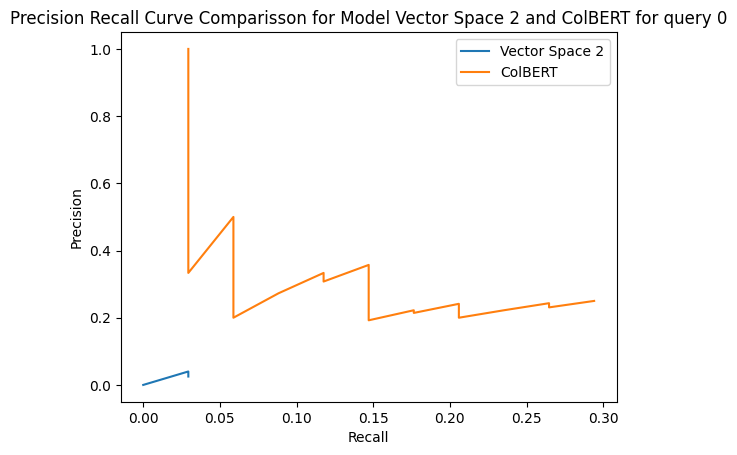

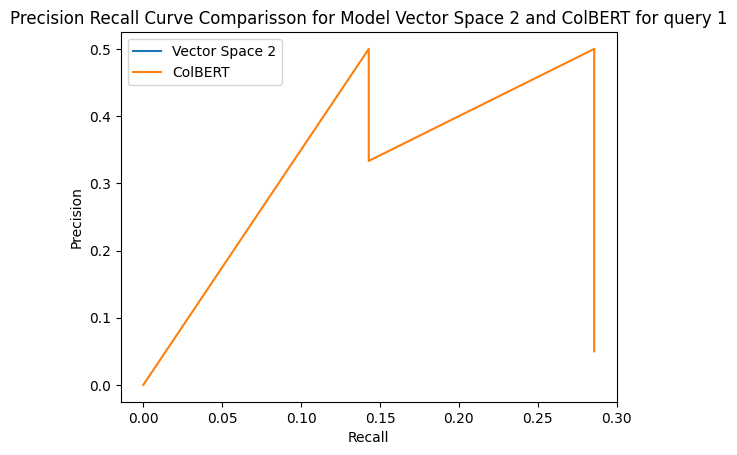

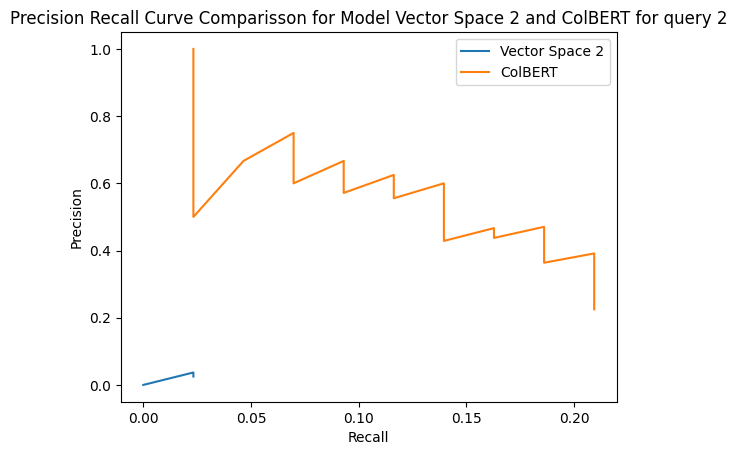

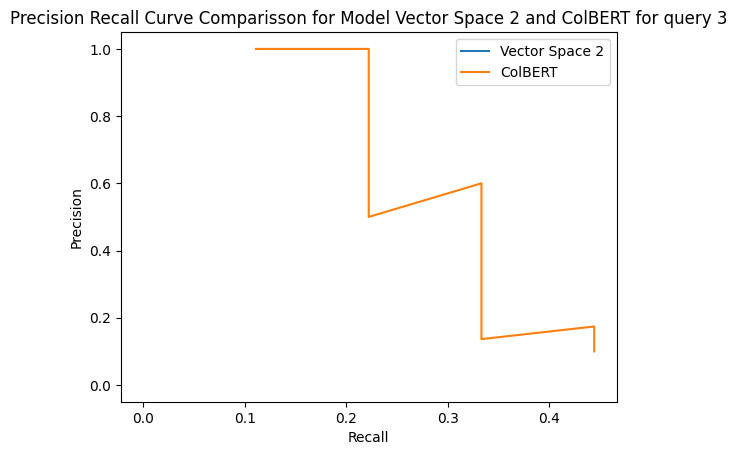

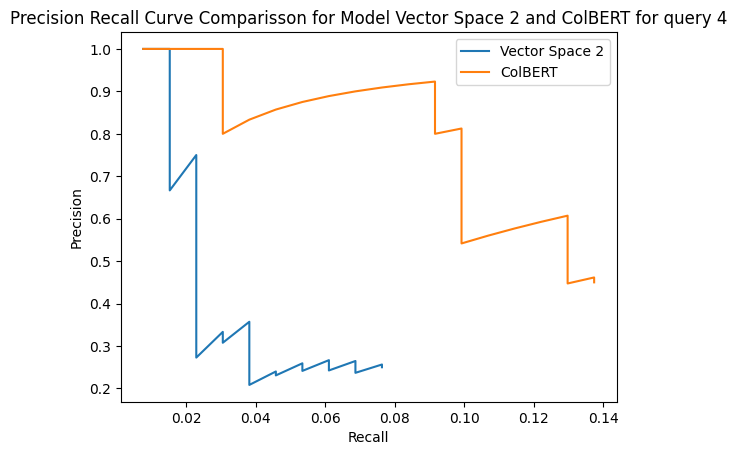

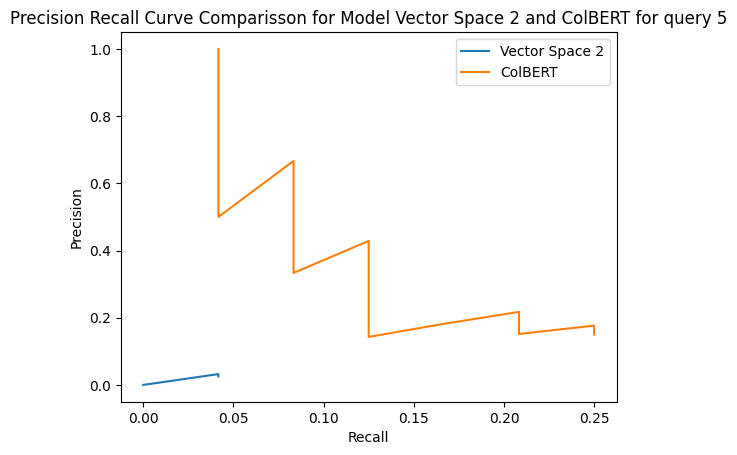

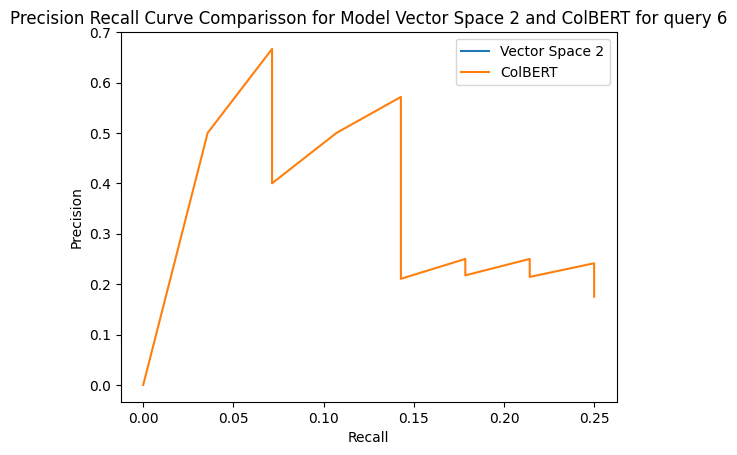

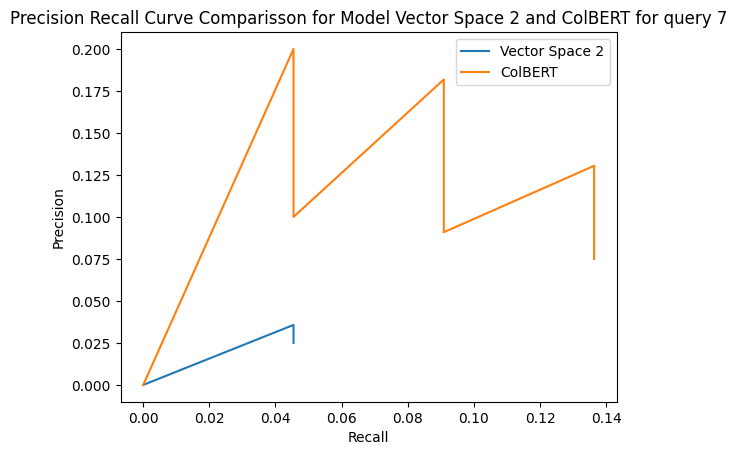

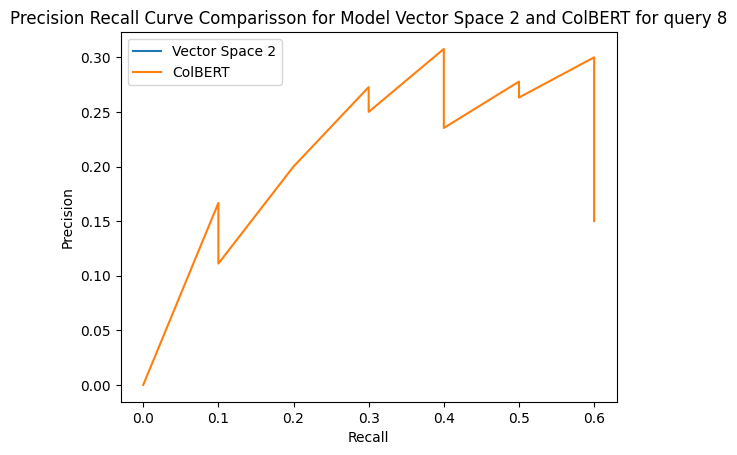

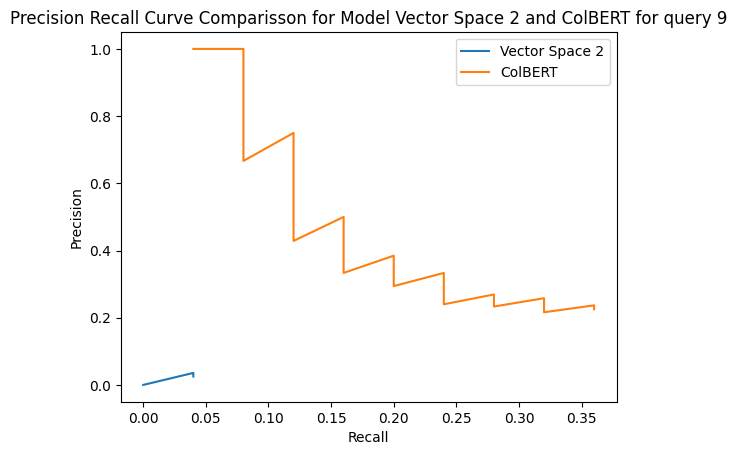

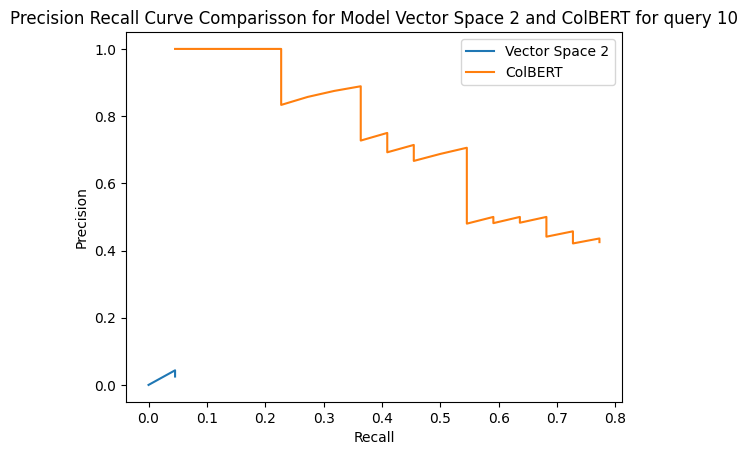

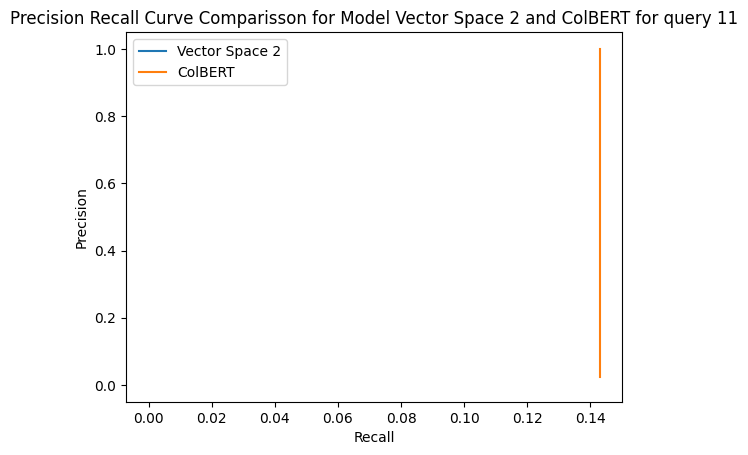

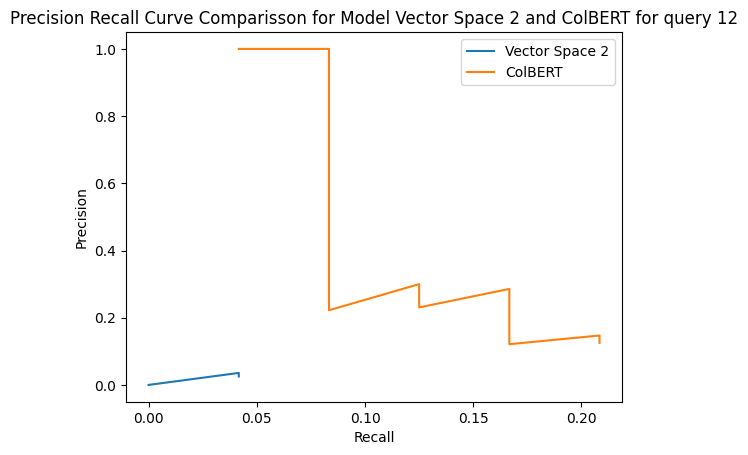

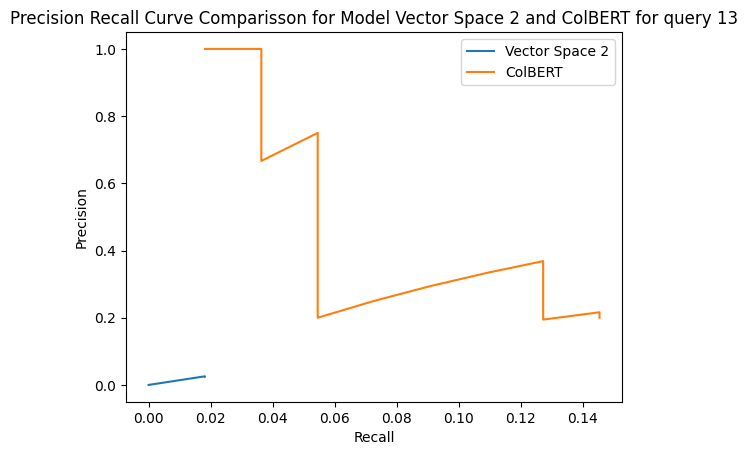

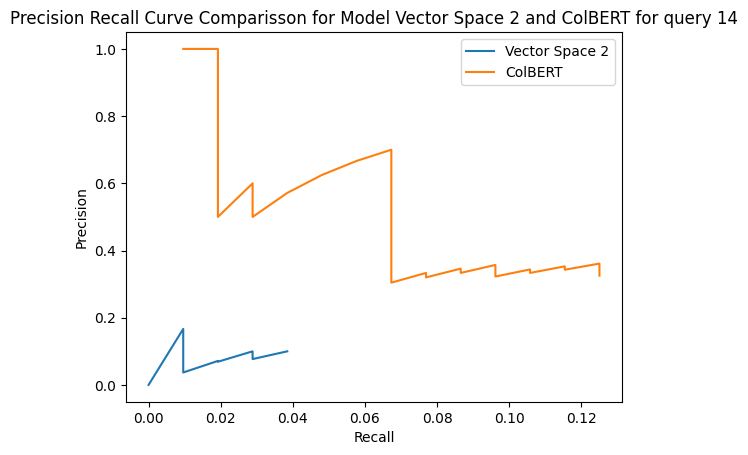

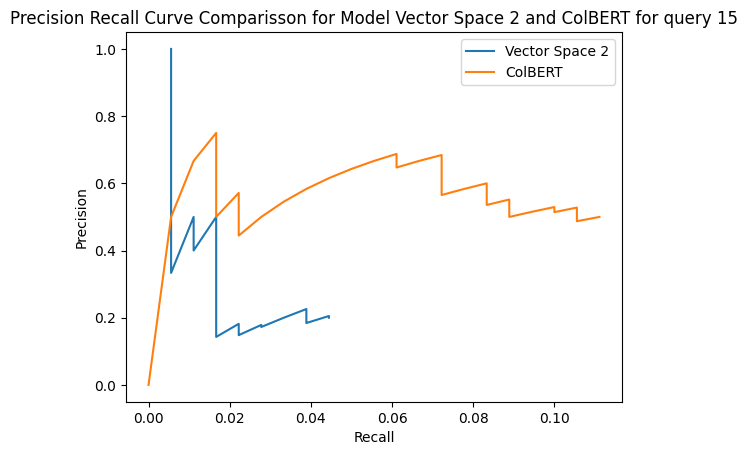

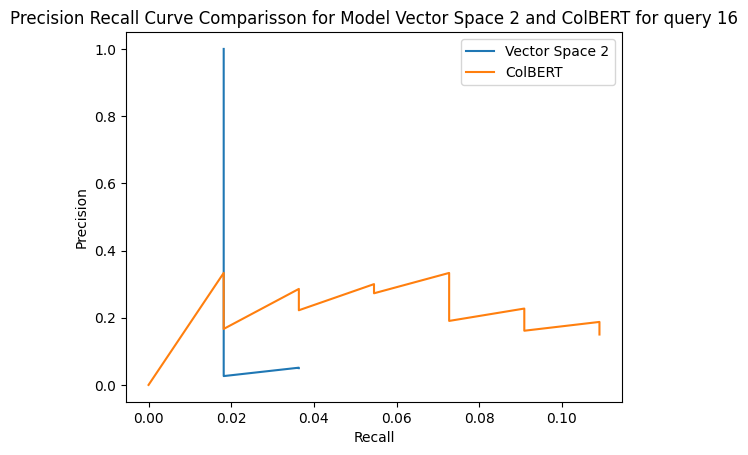

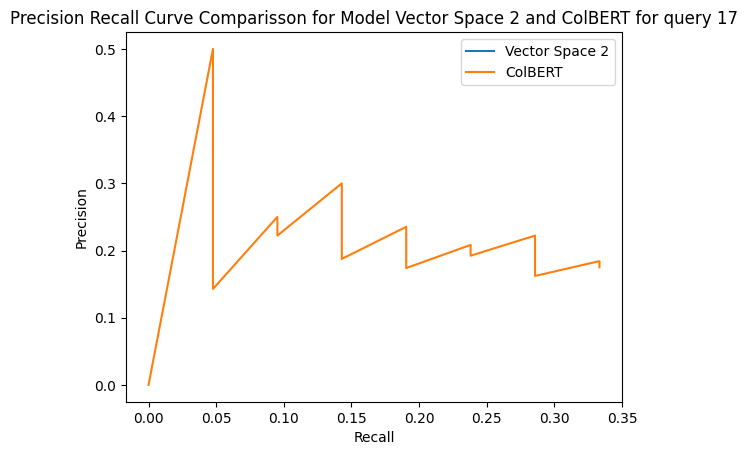

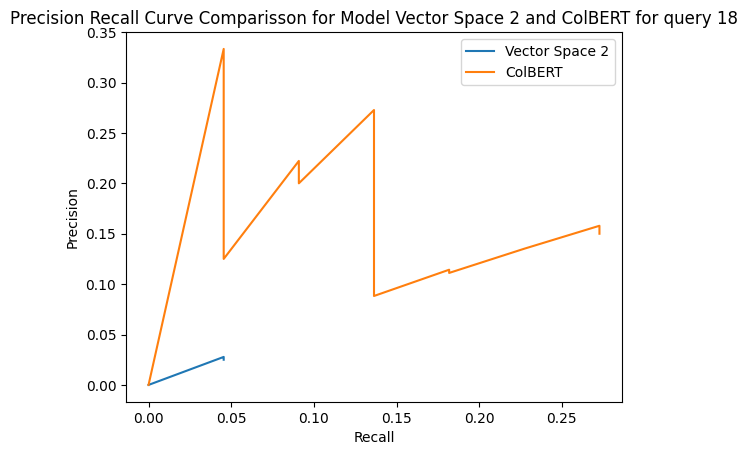

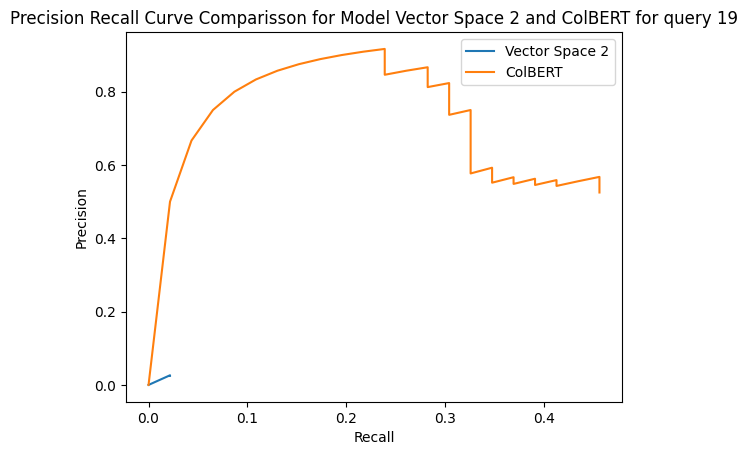

In [23]:
for i in range(20):
    vectorSpace2Results.compare_precision_recall_curve(colbertResults, i)

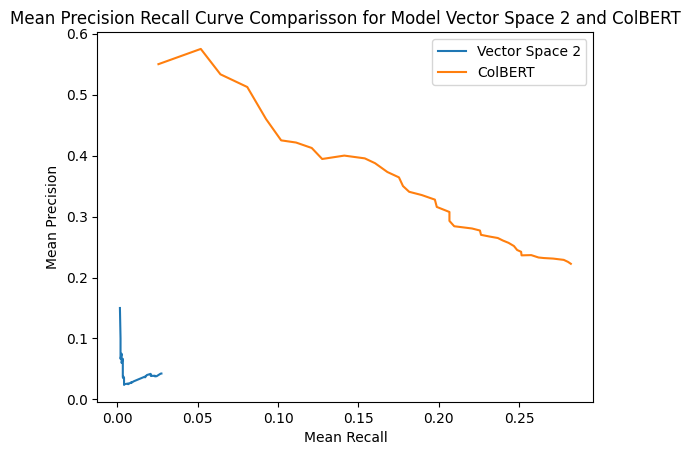

In [24]:
vectorSpace2Results.compare_mean_precision_recall_curve(colbertResults)

Displaying comparison DCG curves for the best Vector Space model and the ColBERT model

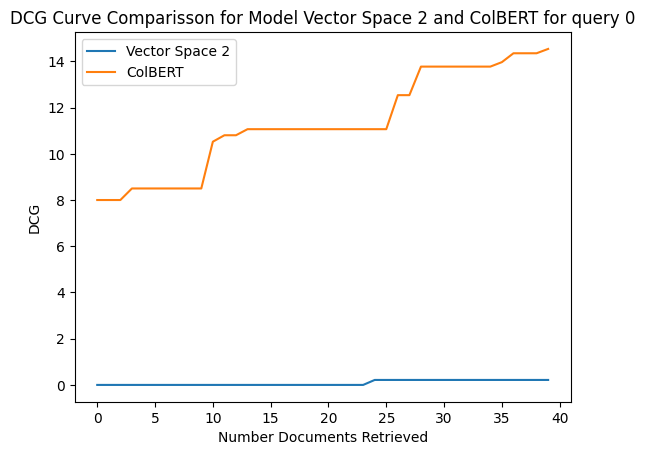

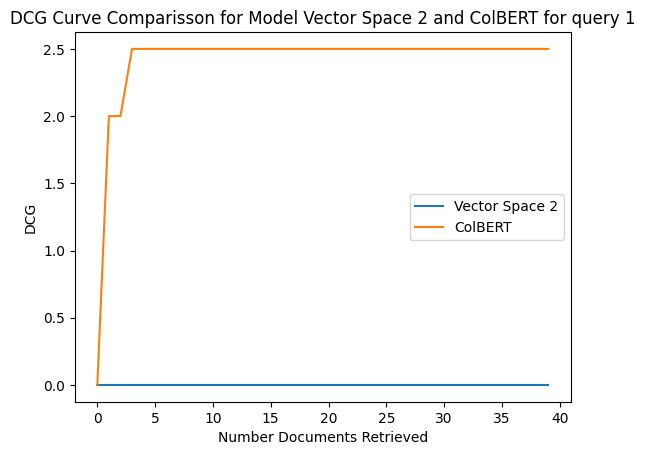

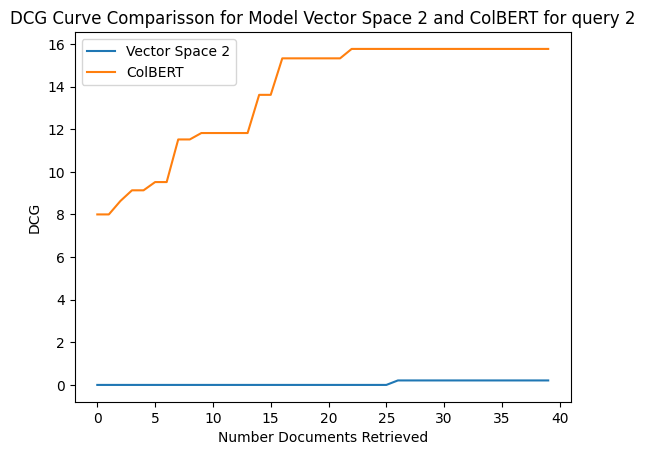

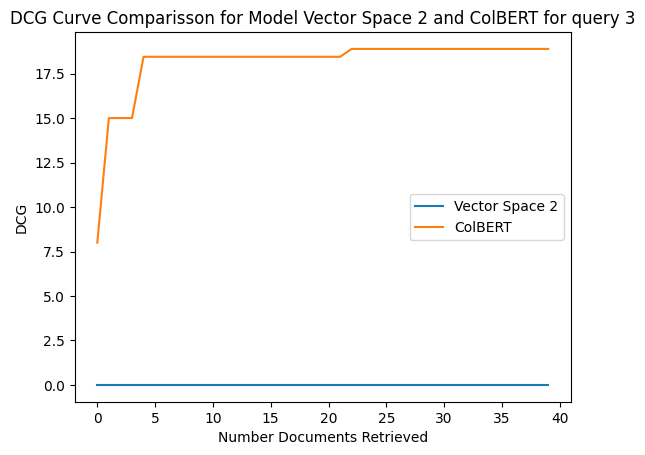

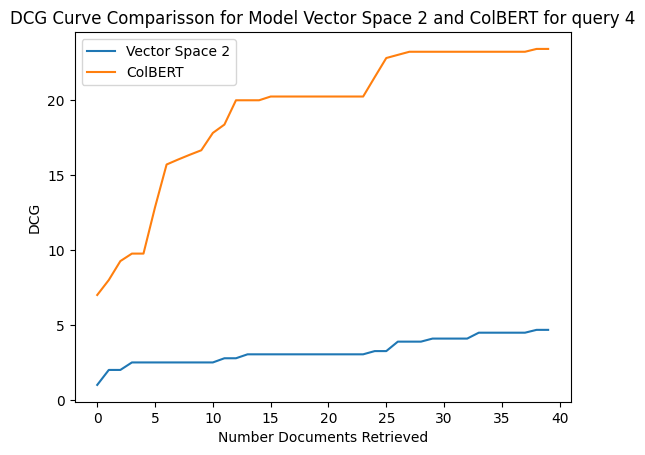

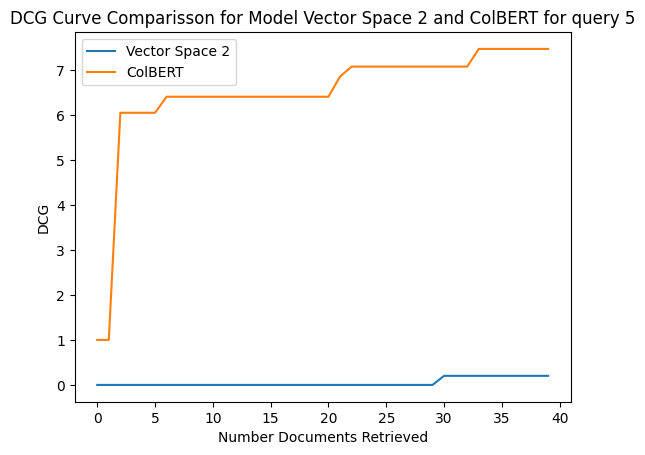

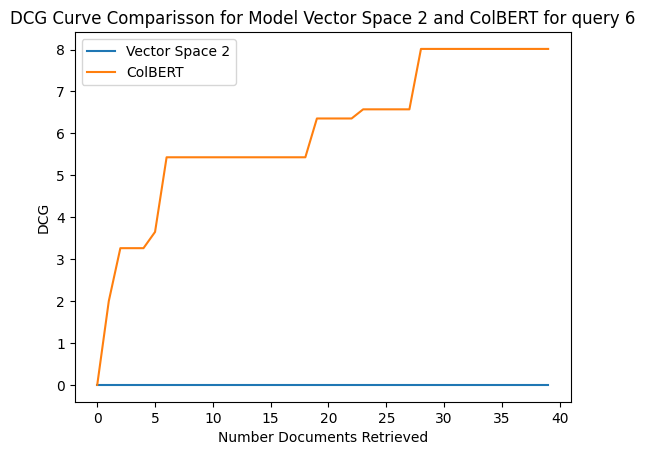

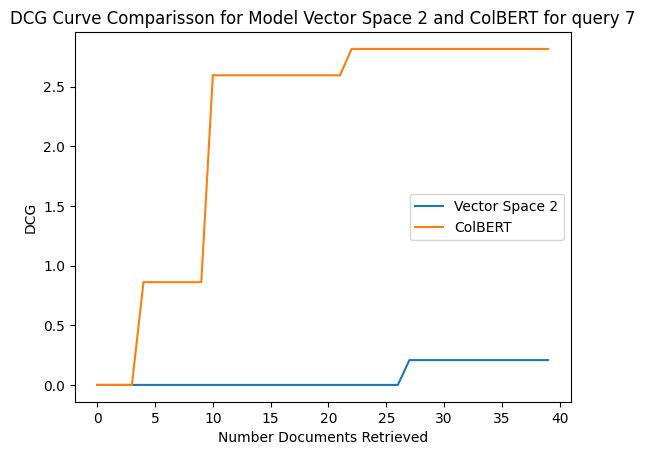

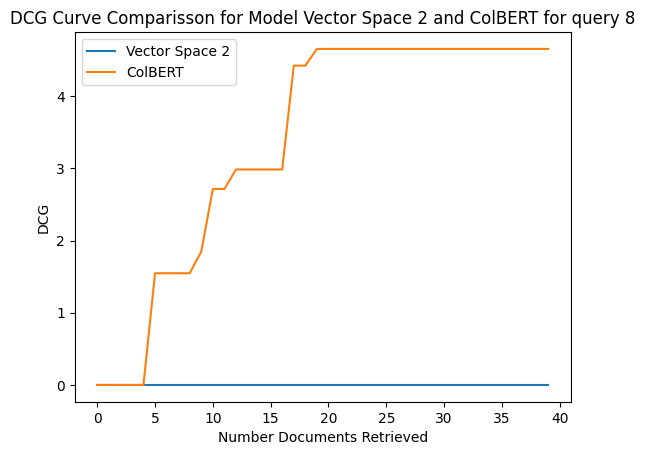

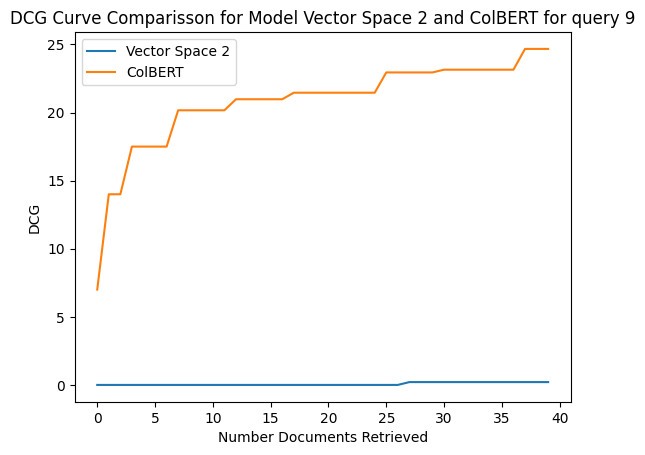

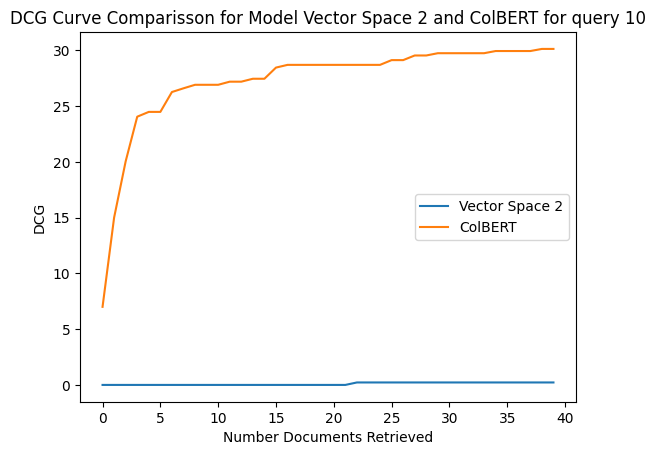

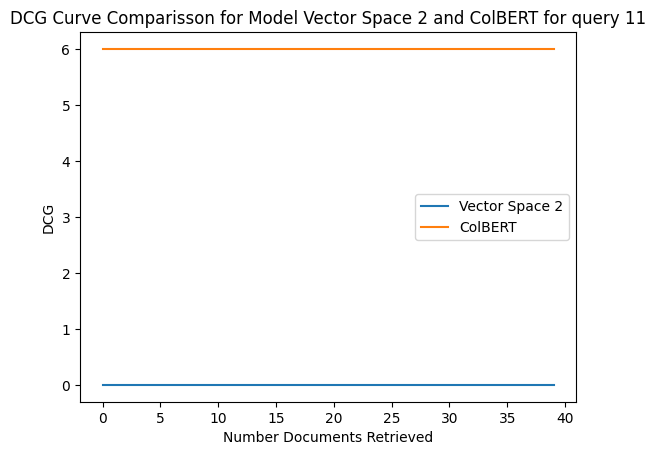

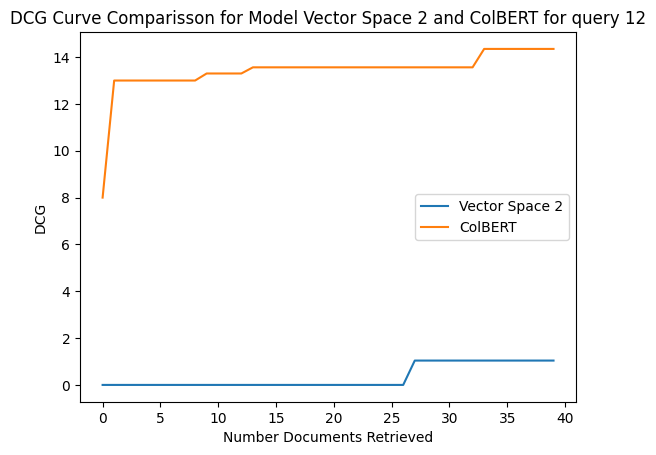

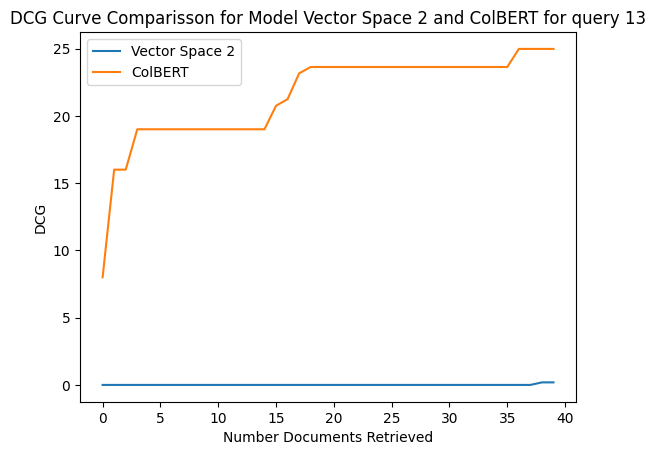

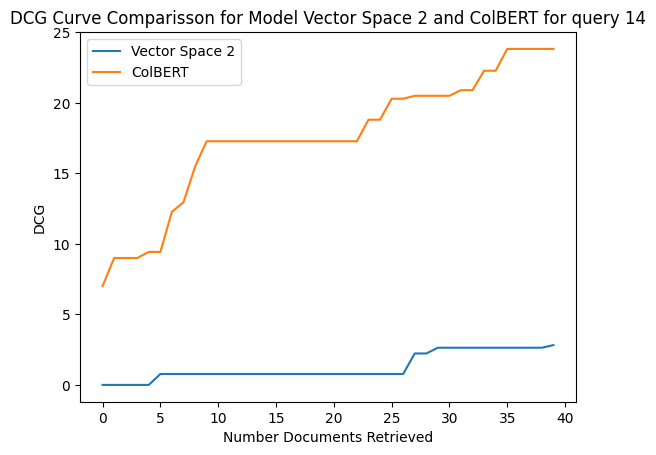

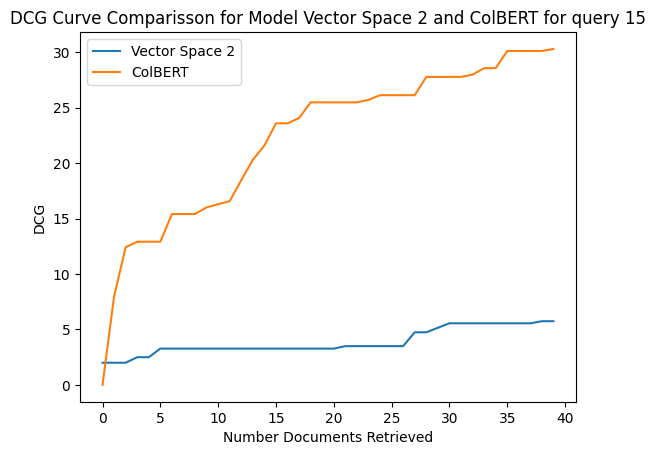

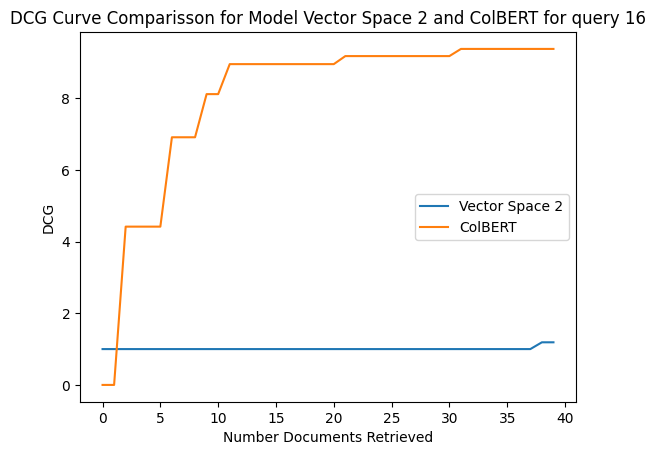

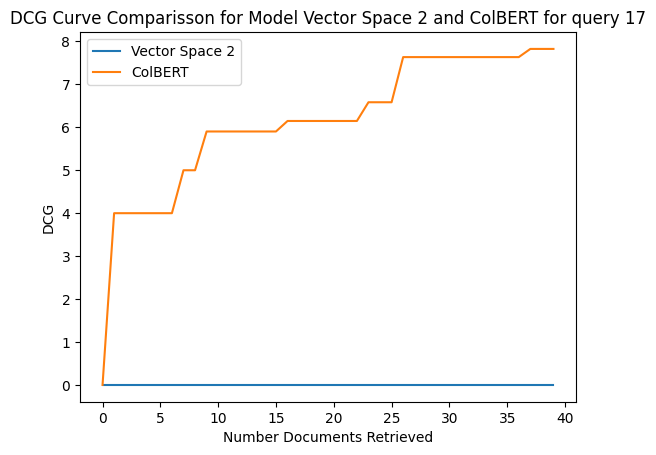

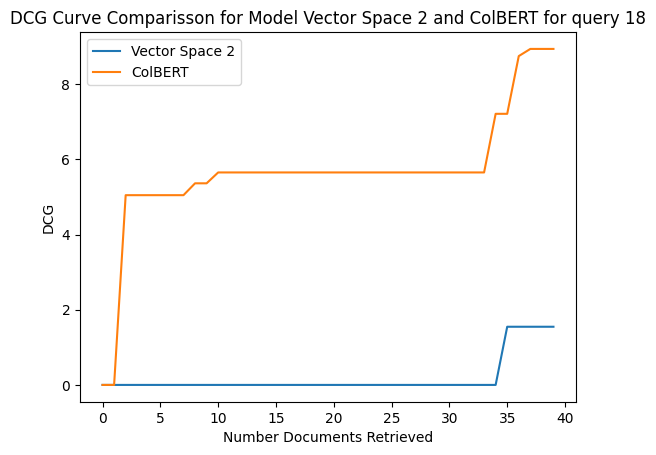

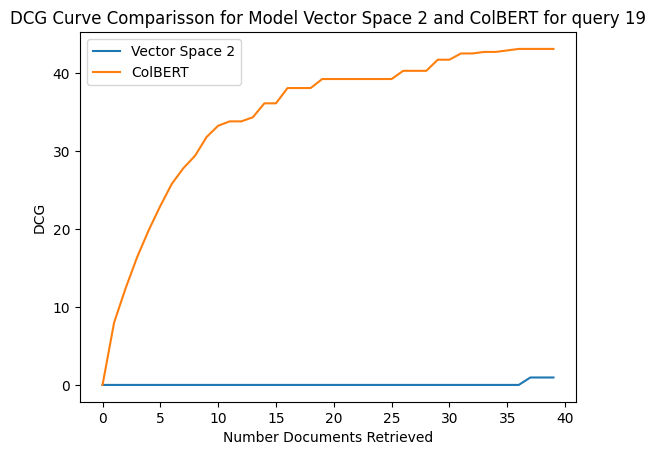

In [25]:
for i in range(20):
    vectorSpace2Results.compare_dcg_curve(colbertResults, i)

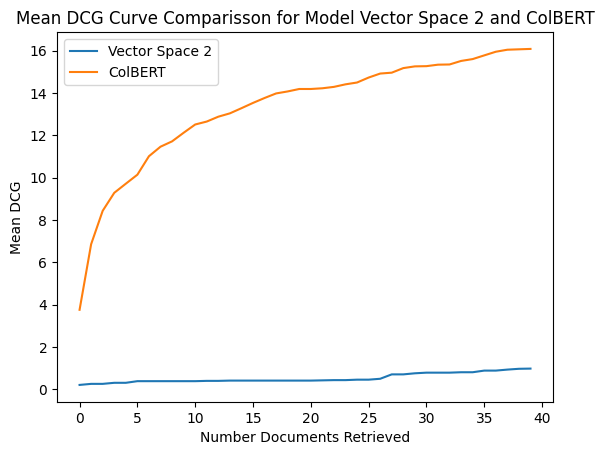

In [26]:
vectorSpace2Results.compare_mean_dcg_curve(colbertResults)

Displaying comparison precision recall curves for the two Vector Space models

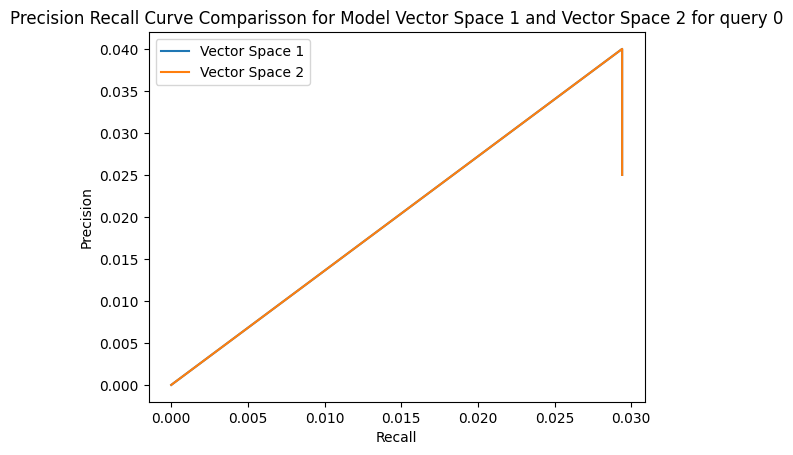

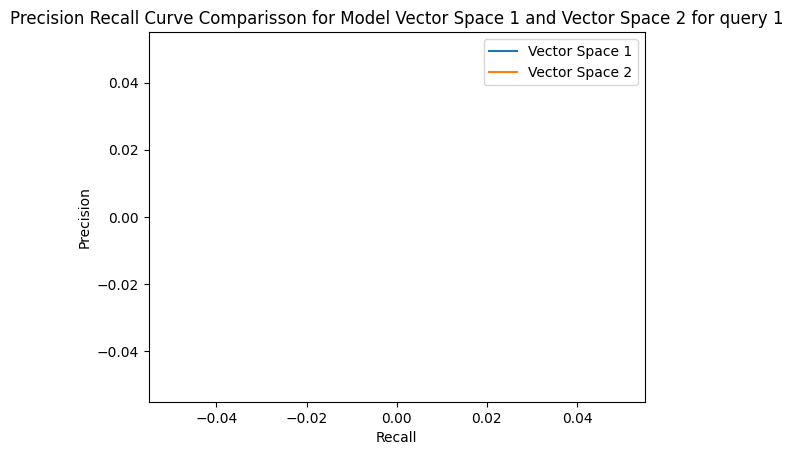

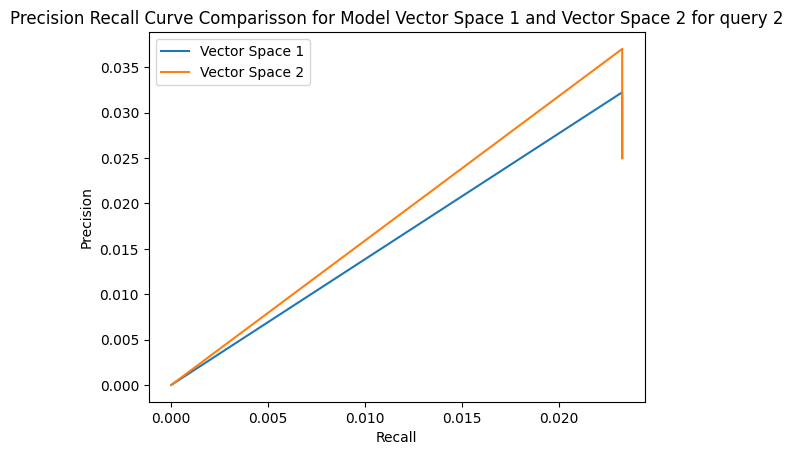

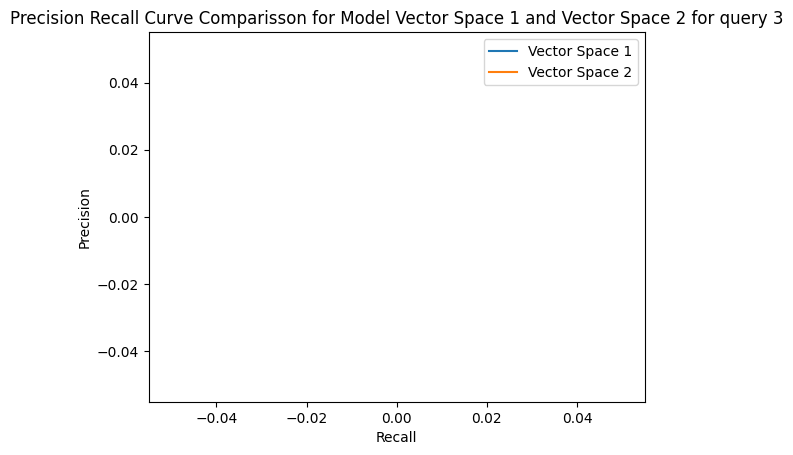

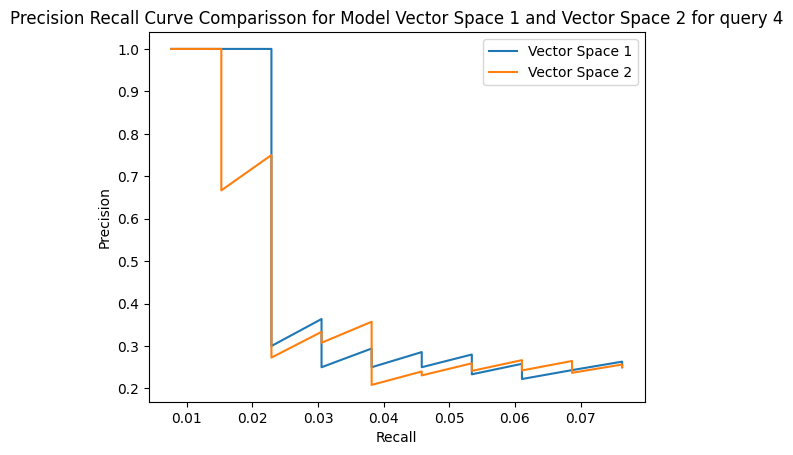

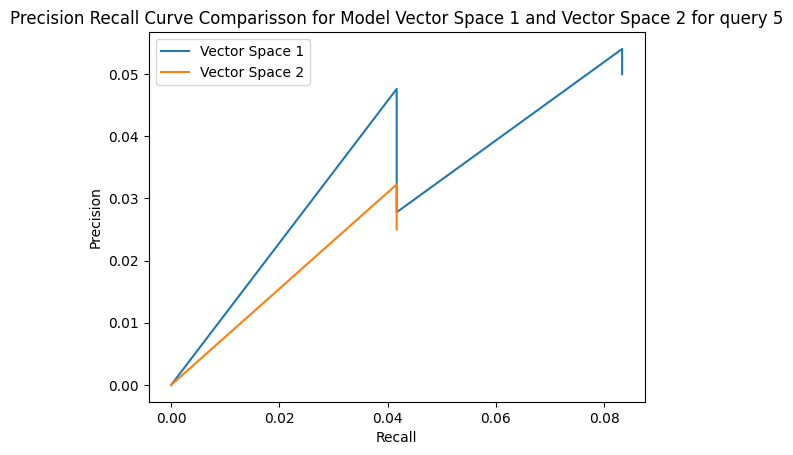

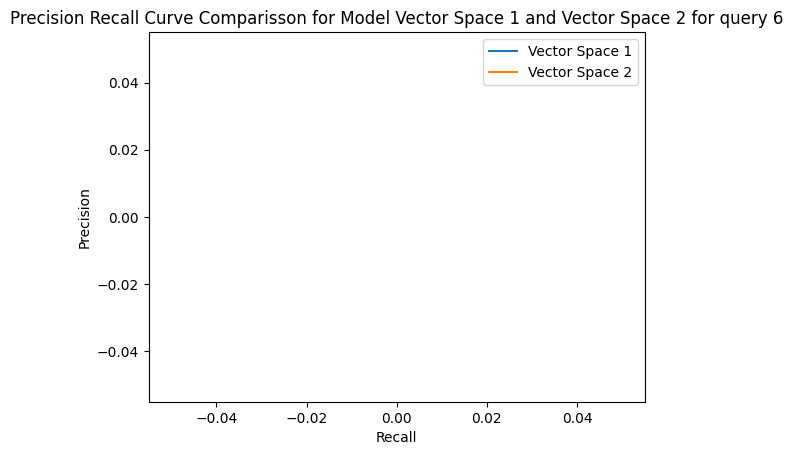

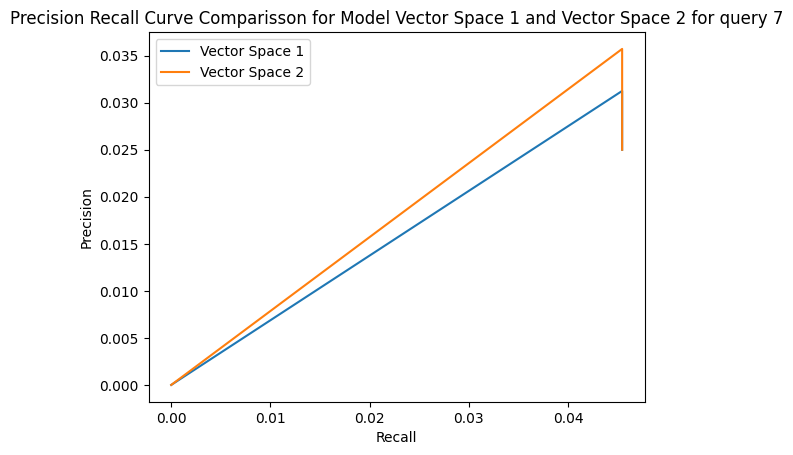

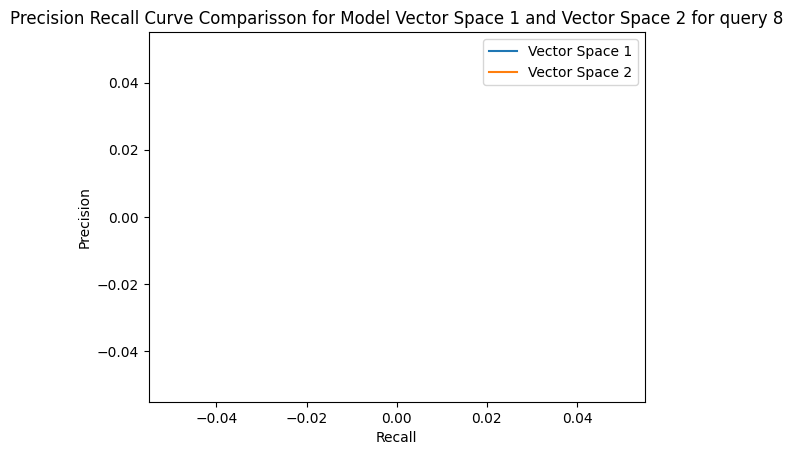

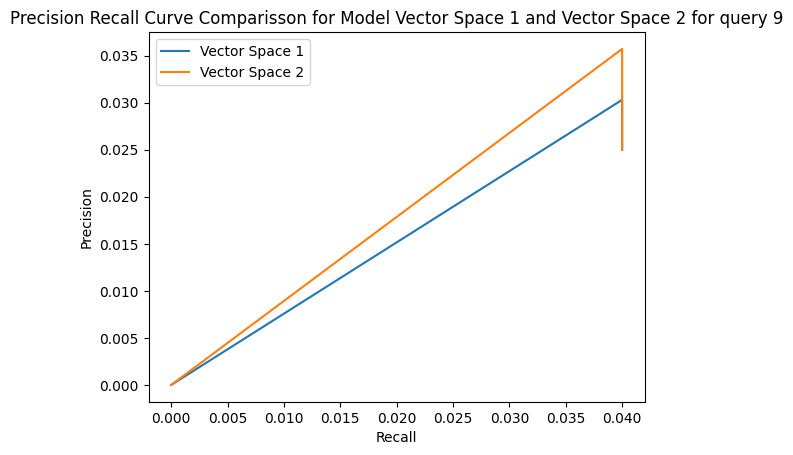

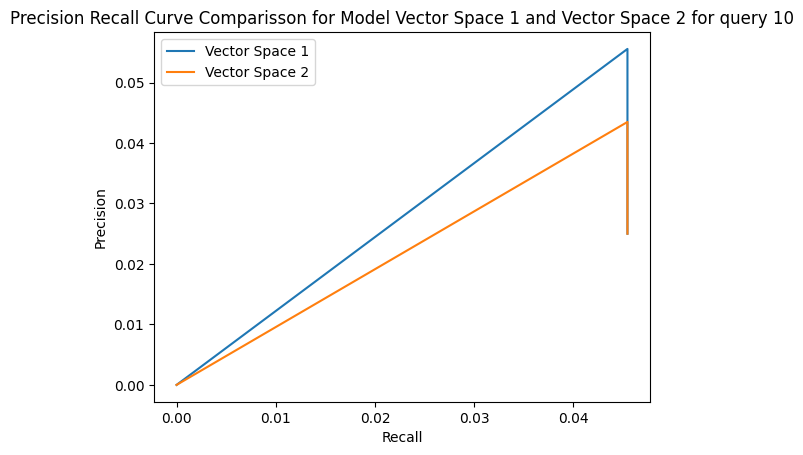

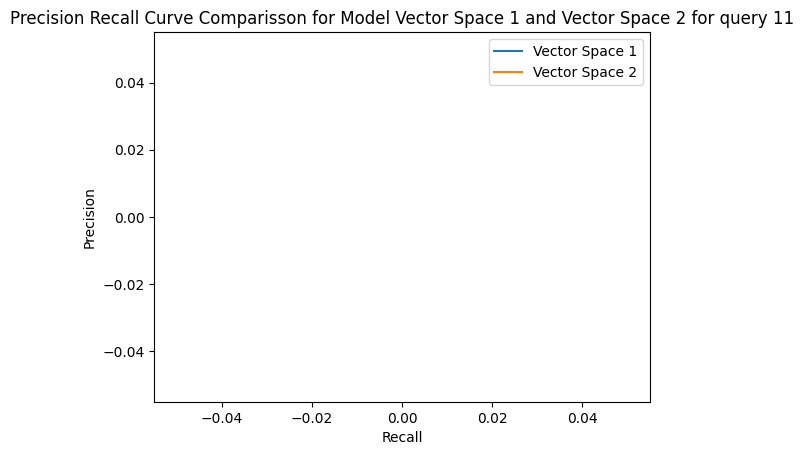

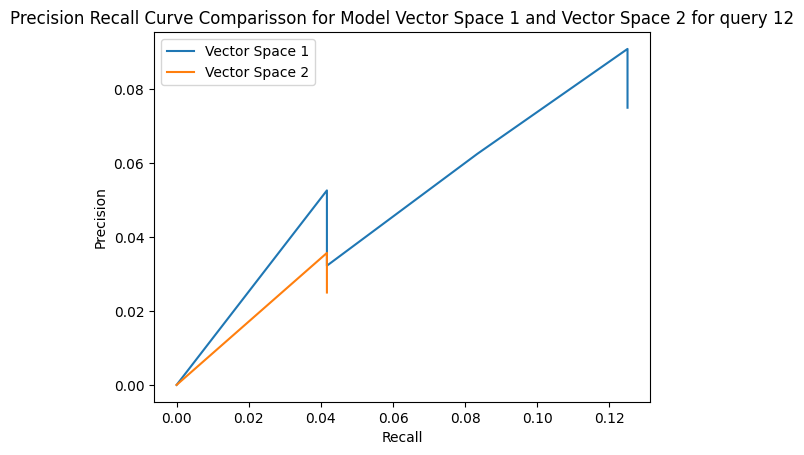

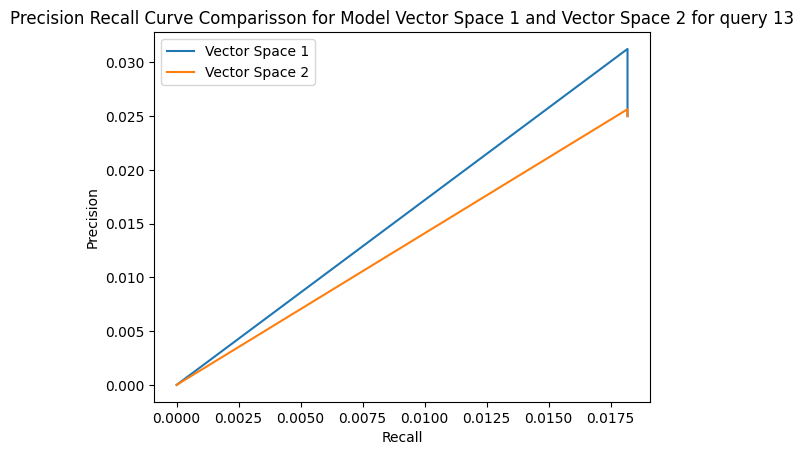

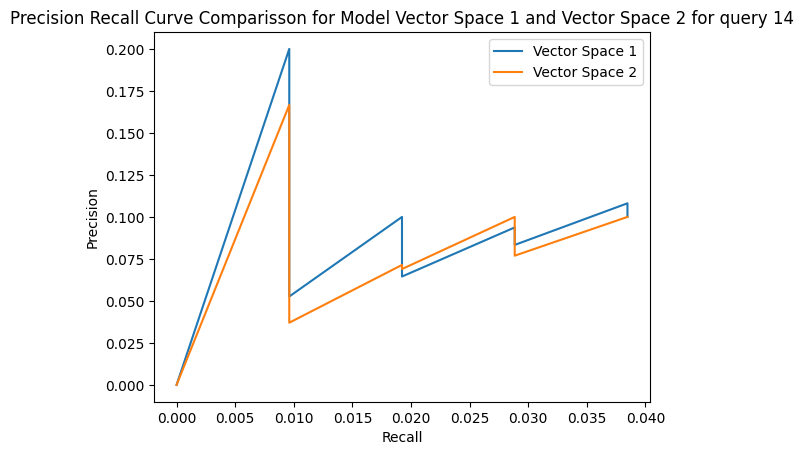

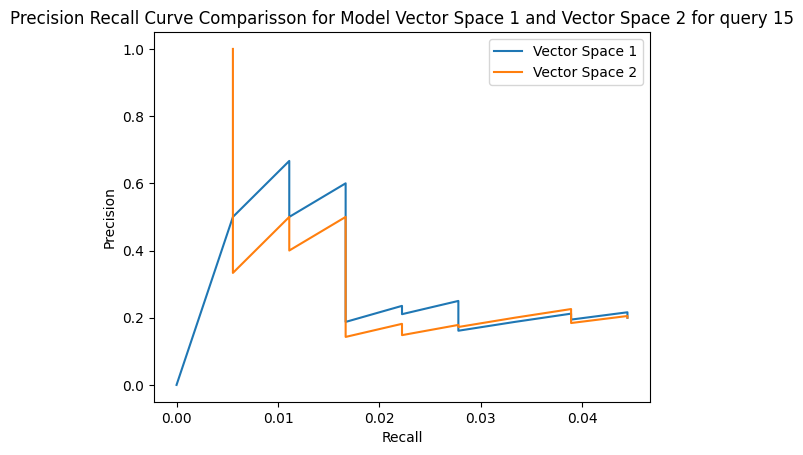

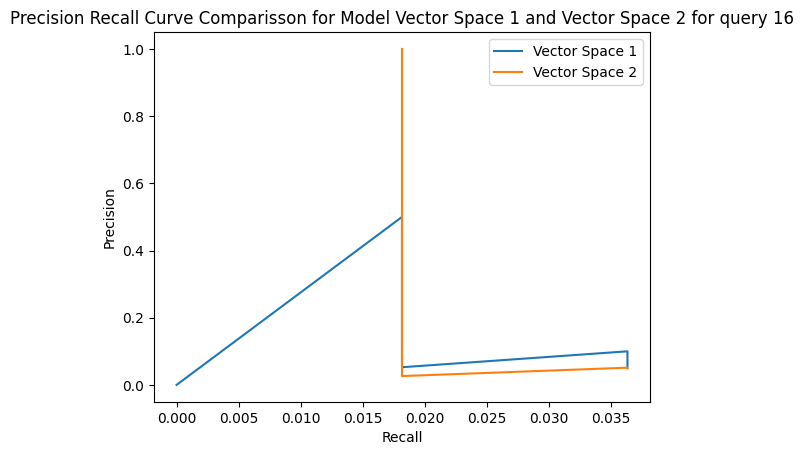

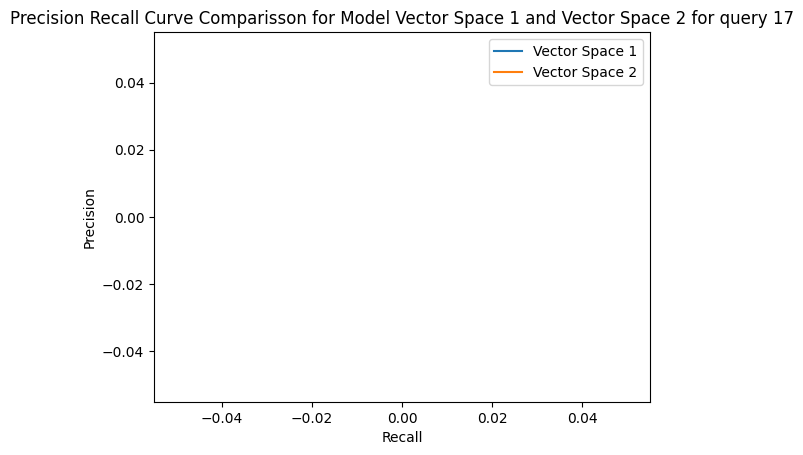

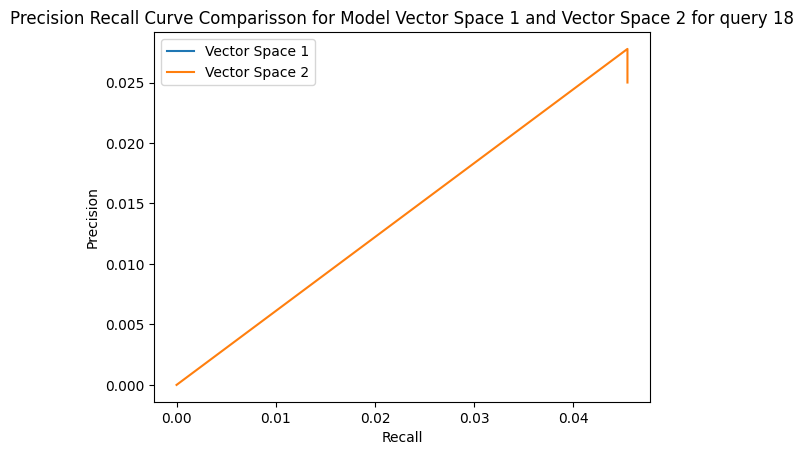

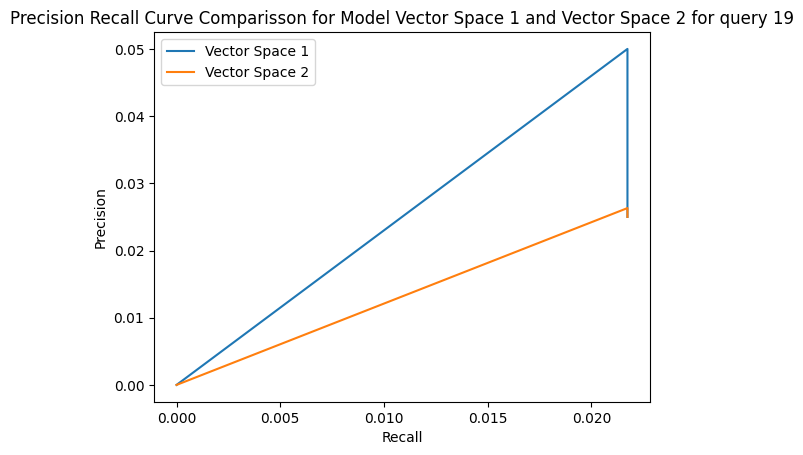

In [27]:
for i in range(20):
    vectorSpace1Results.compare_precision_recall_curve(vectorSpace2Results, i)

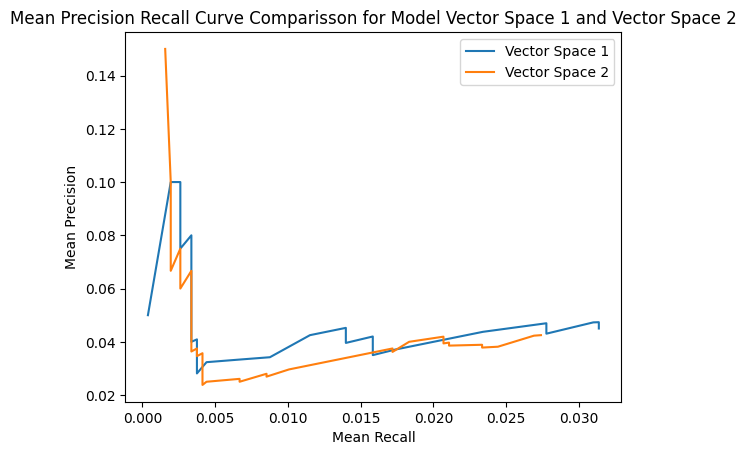

In [28]:
vectorSpace1Results.compare_mean_precision_recall_curve(vectorSpace2Results)

Displaying comparison DCG curves for the two Vector Space models

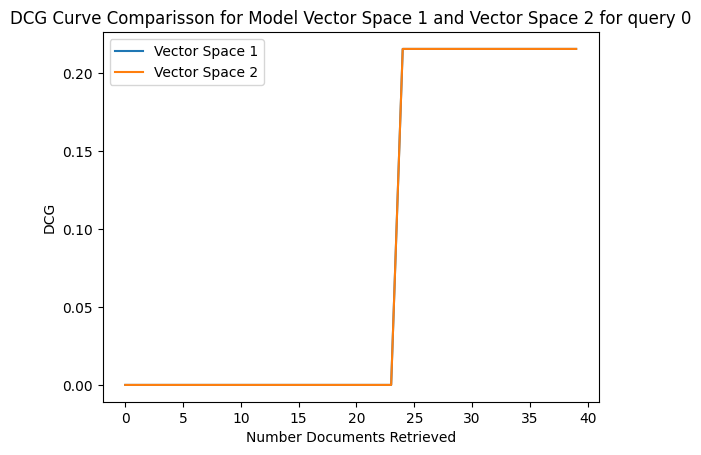

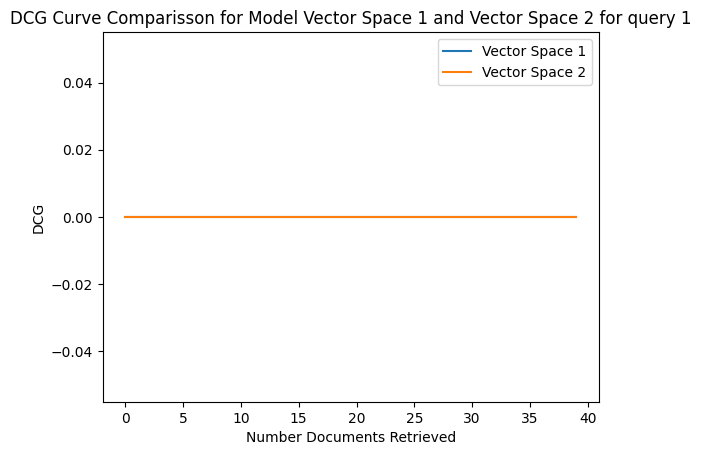

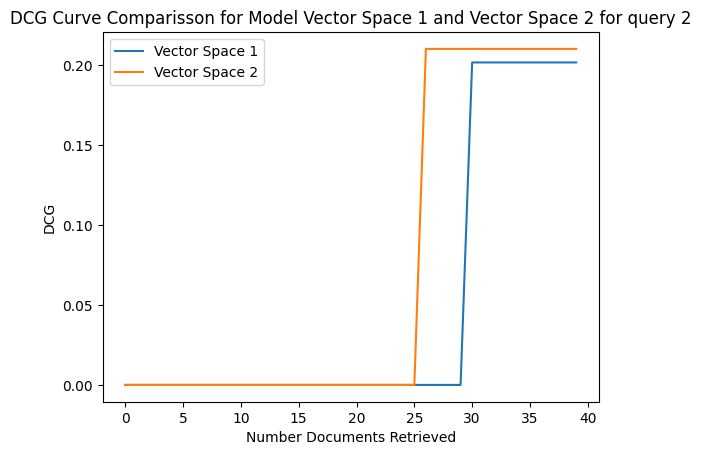

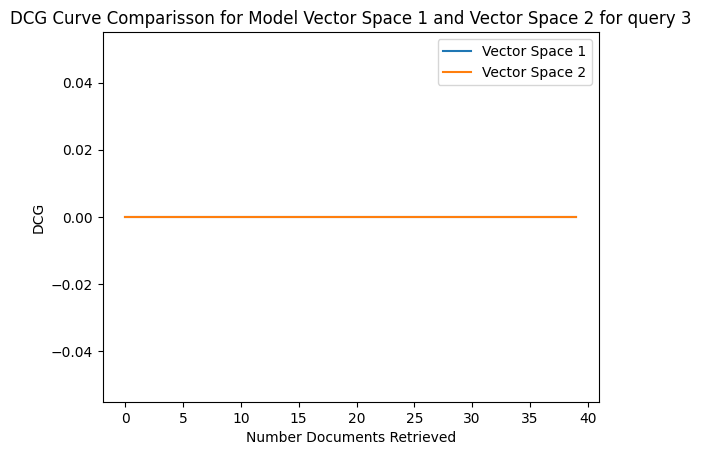

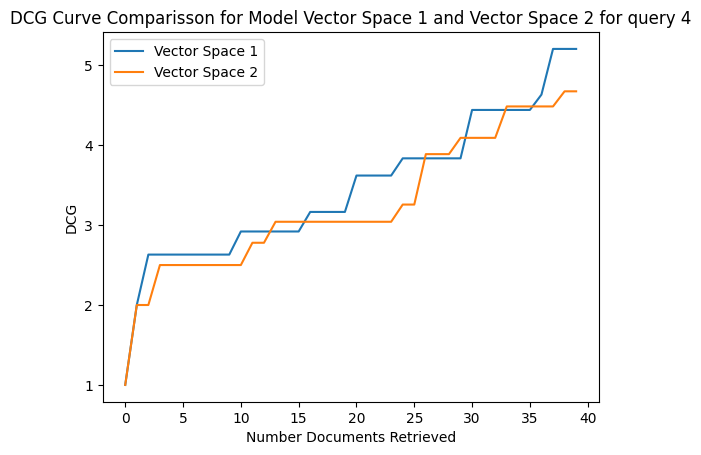

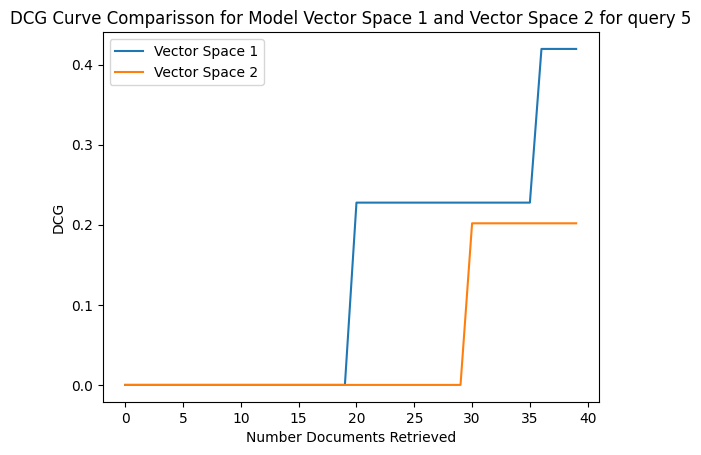

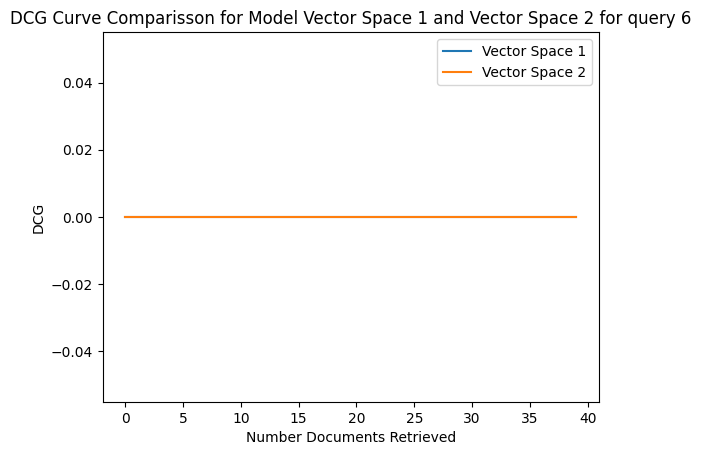

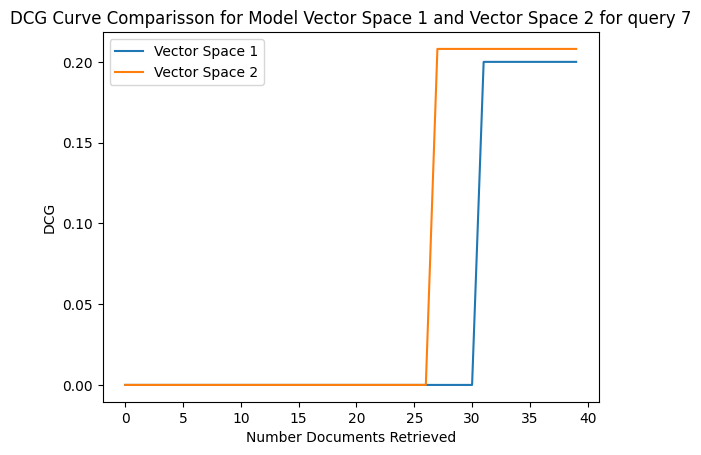

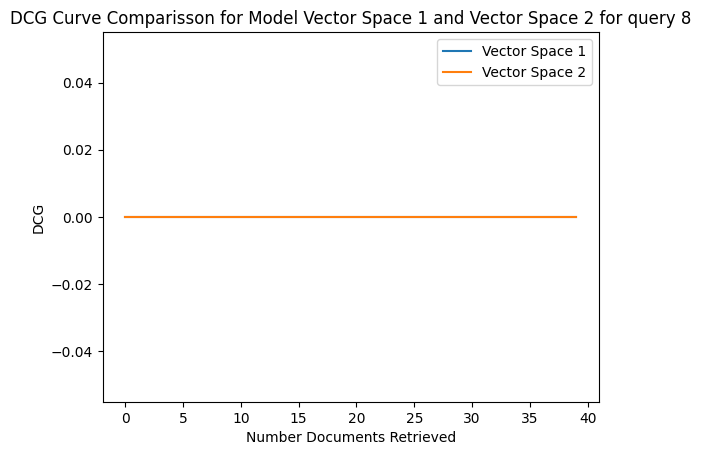

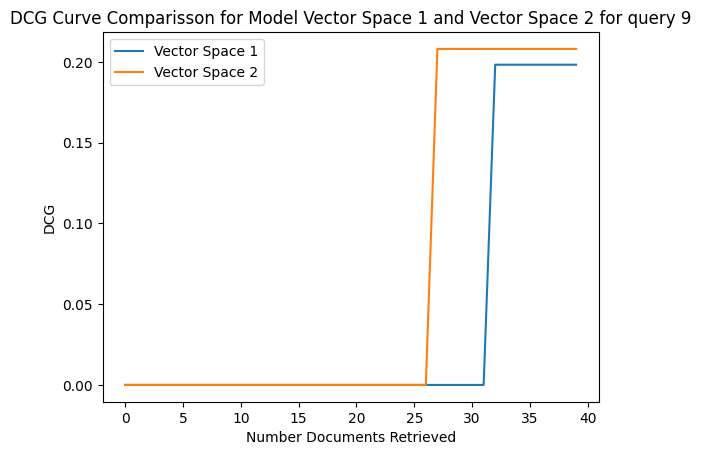

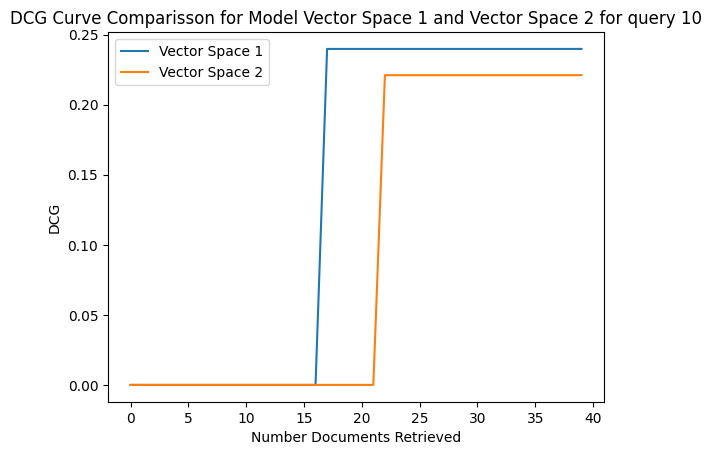

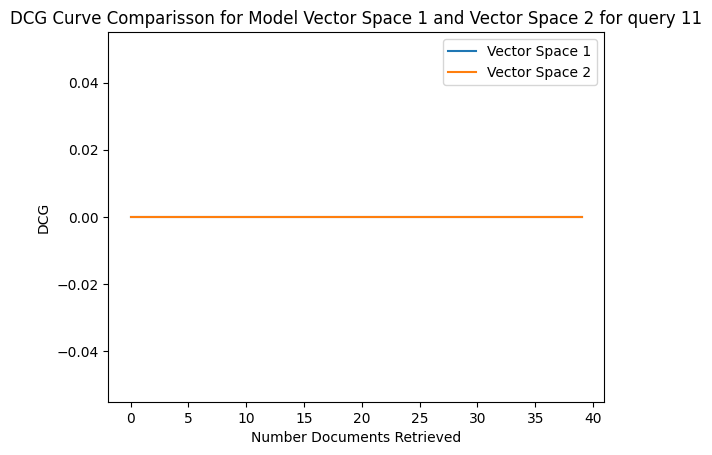

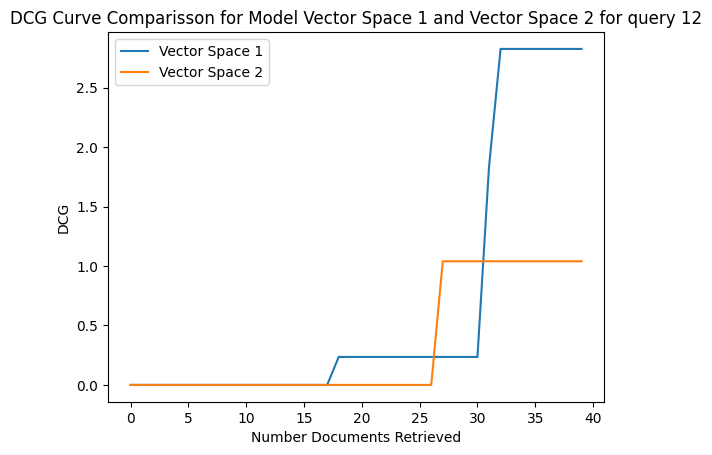

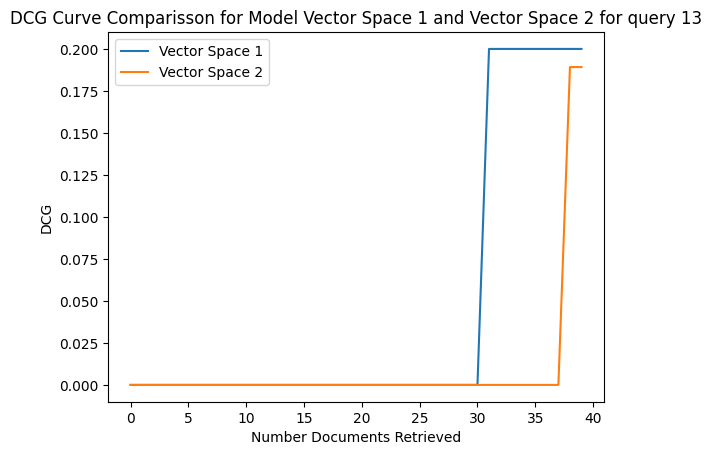

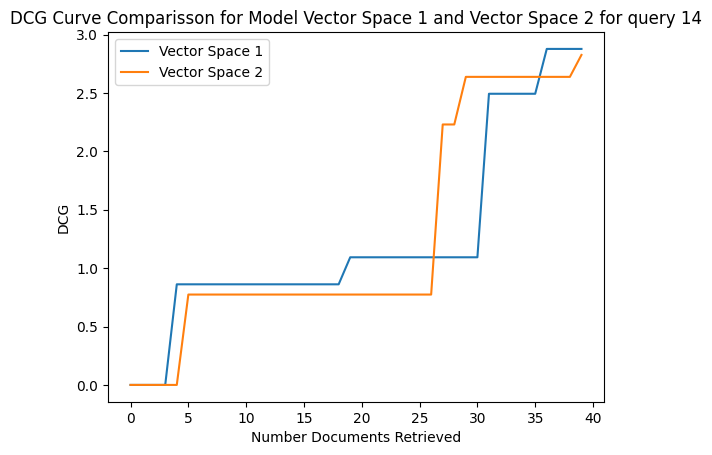

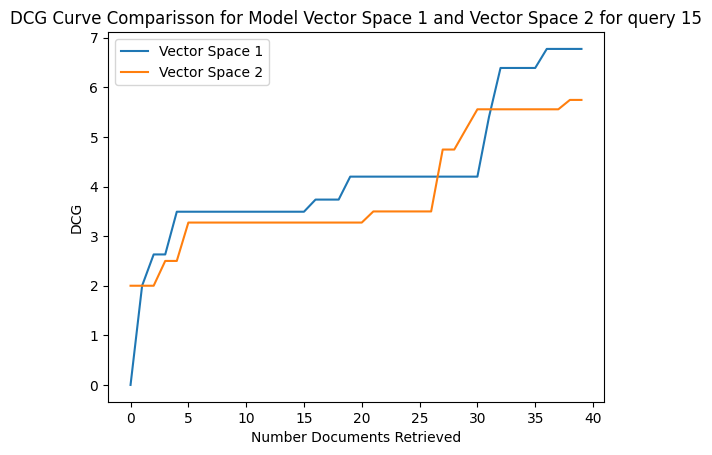

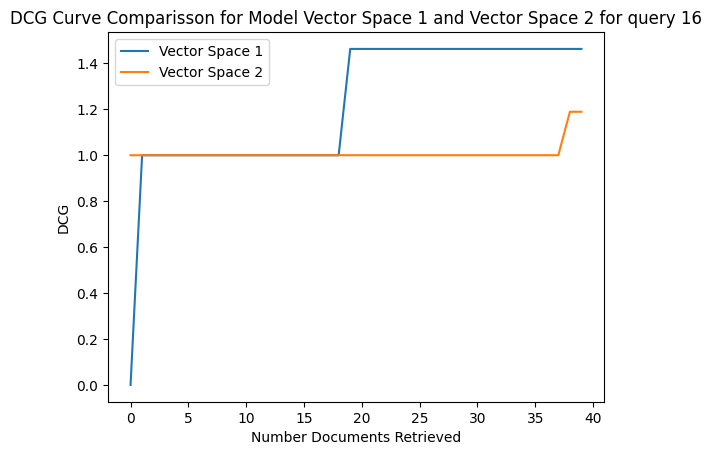

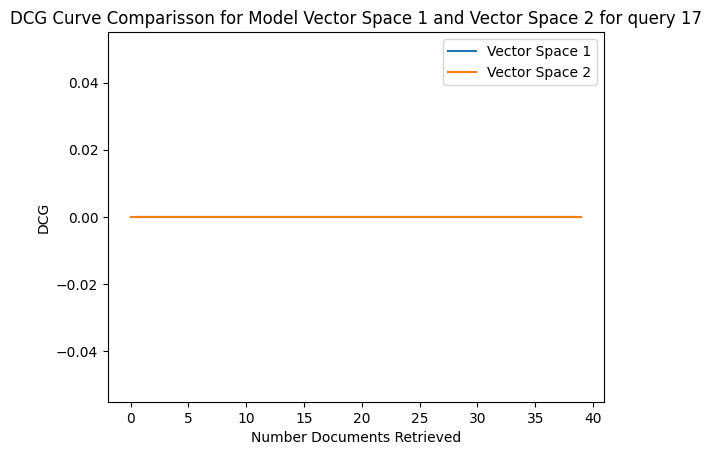

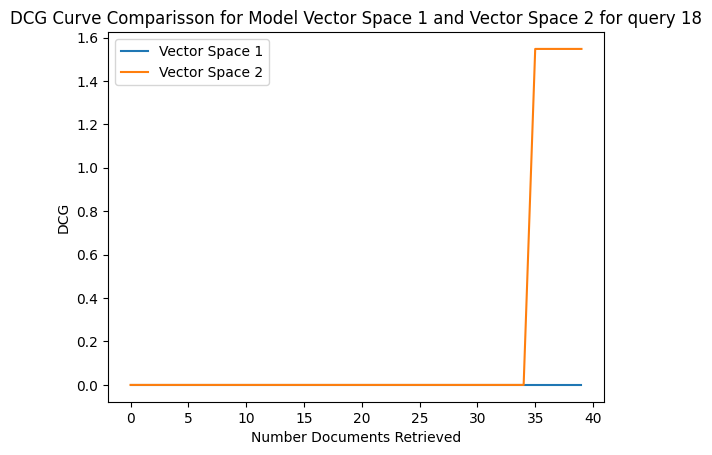

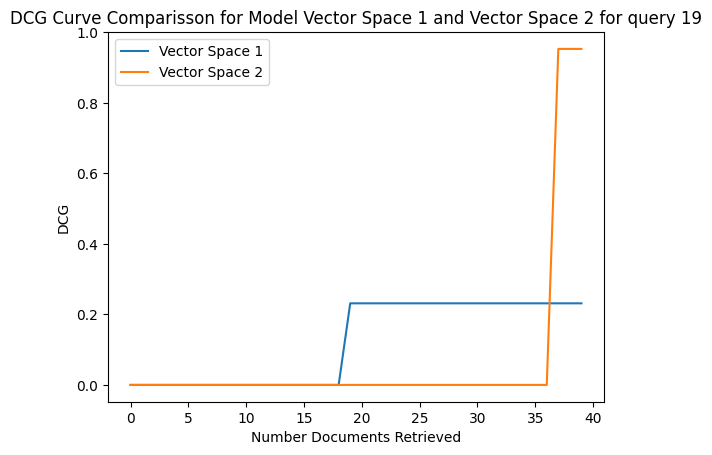

In [29]:
for i in range(20):
    vectorSpace1Results.compare_dcg_curve(vectorSpace2Results, i)

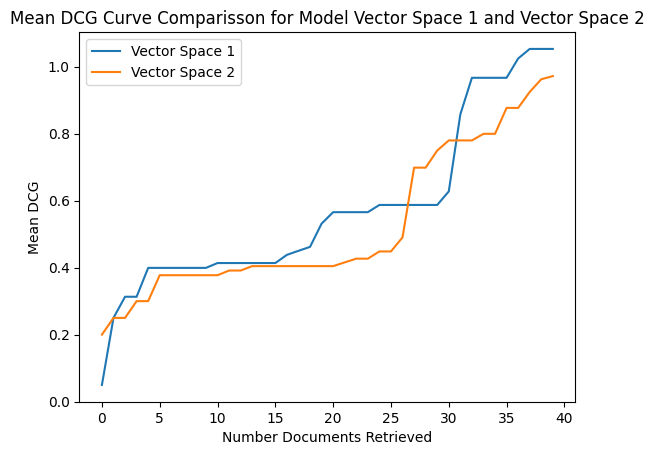

In [30]:
vectorSpace1Results.compare_mean_dcg_curve(vectorSpace2Results)